In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [2]:
from src.utils.filter import convfilt

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_pop2')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_pop2.pickle


In [6]:
ltdk_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/ltdk'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_pop2')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/ltdk/ltdk_pop2.pickle


In [7]:
def to_color(r,g,b):
    return (r/255, g/255, b/255)
hffm.cmap_movclusts = {
    'all': 'k',
    'movement': to_color(230,135,45), # orange
    'early': to_color(44,140,109), # green
    'late': to_color(46,131,232), # blue
    'biphasic': to_color(222,190,43), # yellow
    'negative': to_color(111,61,175), # purple
    'unresponsive': 'dimgray',
}
ltdk.cmap_movclusts = hffm.cmap_movclusts

In [8]:
def modind(a, b):
    """
    value of 1 means a is more significant
    value of -1 means b is more significant
    """
    mi = (a - b) / (a + b)
    return mi

def direcpref_scatter_c(panel, xname, yname):
    for i in range(4):
        name = ['early','late','biphasic','negative'][i]
        x_mi = hffm.data[xname][hffm.data['movcluster']==name]
        y_mi = hffm.data[yname][hffm.data['movcluster']==name]
        panel.plot(x_mi, y_mi, '.', color=hffm.cmap_movclusts[i+1], markersize=8)
    panel.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    panel.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')

In [9]:
for ind, row in hffm.data[hffm.data['fr']>2].iterrows():
    if row['movcluster'] in ['early','late','biphasic','negative']:
        if row['pref_gazeshift_direction']=='L':
            pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        elif row['pref_gazeshift_direction']=='R':
            pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        
        if row['pref_gazeshift_direction']=='L':
            left_gaze = pref_gaze; right_gaze = nonpref_gaze
            left_comp = pref_comp; right_comp = nonpref_comp
        elif row['pref_gazeshift_direction']=='R':
            right_gaze = pref_gaze; left_gaze = nonpref_gaze
            right_comp = pref_comp; left_comp = nonpref_comp
        
        hffm.data.at[ind, 'gaze_sacc_rlMI'] = modind(np.max(right_gaze), np.max(left_gaze))
        hffm.data.at[ind, 'comp_sacc_rlMI'] = modind(np.max(right_comp), np.max(left_comp))
        hffm.data.at[ind, 'gaze_sacc_pnpMI'] = modind(np.max(pref_gaze), np.max(nonpref_gaze))
        hffm.data.at[ind, 'comp_sacc_pnpMI'] = modind(np.max(pref_comp), np.max(nonpref_comp))
        
    if row['responsive_to_gratings']:
        ori = row['Gt_ori_tuning_mean_tf']
        best_sf = ori[:,np.argmax(np.mean(ori,0))]
        left_grat = best_sf[0]
        right_grat = best_sf[4]
        hffm.data.at[ind, 'gratings_rlMI'] = modind(right_grat, left_grat)
        
for ind, row in ltdk.data[ltdk.data['fr']>2].iterrows():
    if row['movcluster'] in ['early','late','biphasic','negative']:
        if row['pref_gazeshift_direction']=='L':
            pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        elif row['pref_gazeshift_direction']=='R':
            pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
            nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        
        if row['pref_gazeshift_direction']=='L':
            left_gaze = pref_gaze; right_gaze = nonpref_gaze
            left_comp = pref_comp; right_comp = nonpref_comp
        elif row['pref_gazeshift_direction']=='R':
            right_gaze = pref_gaze; left_gaze = nonpref_gaze
            right_comp = pref_comp; left_comp = nonpref_comp
        
        ltdk.data.at[ind, 'gaze_sacc_rlMI'] = modind(np.max(right_gaze), np.max(left_gaze))
        ltdk.data.at[ind, 'comp_sacc_rlMI'] = modind(np.max(right_comp), np.max(left_comp))
        ltdk.data.at[ind, 'gaze_sacc_pnpMI'] = modind(np.max(pref_gaze), np.max(nonpref_gaze))
        ltdk.data.at[ind, 'comp_sacc_pnpMI'] = modind(np.max(pref_comp), np.max(nonpref_comp))

In [71]:
hffm.data['early_movement'] = False
for ind, row in hffm.data[hffm.data['movcluster']=='early'].iterrows():
    if np.abs(row['gaze_sacc_rlMI']) >= 0.33:
        hffm.data.at[ind, 'early_movement'] = True
        
ltdk.data['early_movement'] = False
for ind, row in ltdk.data[ltdk.data['movcluster']=='early'].iterrows():
    if np.abs(row['gaze_sacc_rlMI']) >= 0.33:
        ltdk.data.at[ind, 'early_movement'] = True

In [72]:
hffm.data['movcluster1'] = hffm.data['movcluster'].copy()
for ind, row in hffm.data.iterrows():
    if row['movcluster1']=='early' and row['early_movement']==True:
        hffm.data.at[ind, 'movcluster1'] = 'movement'
        
ltdk.data['movcluster1'] = ltdk.data['movcluster'].copy()
for ind, row in ltdk.data.iterrows():
    if row['movcluster1']=='early' and row['early_movement']==True:
        ltdk.data.at[ind, 'movcluster1'] = 'movement'

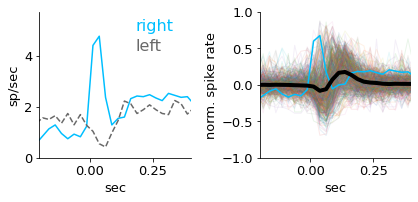

In [13]:
fig, axs = plt.subplots(1,2,figsize=(6,3))

ax_ex_psth = plt.subplot(1,2,1)
ex_unit = 474
right = hffm.data['FmLt_rightsacc_avg_gaze_shift_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==ex_unit].iloc[0]
left = hffm.data['FmLt_leftsacc_avg_gaze_shift_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==ex_unit].iloc[0]
ax_ex_psth.plot(hffm.trange_x, right, color=hffm.cmap_special2[1])
ax_ex_psth.plot(hffm.trange_x, left, color='dimgray', linestyle='dashed')
maxval = np.max(np.maximum(right, left))*1.2
ax_ex_psth.set_ylim([0, maxval])
ax_ex_psth.set_xlim([-0.2, 0.4])
ax_ex_psth.set_ylabel('sp/sec')
ax_ex_psth.set_xlabel('sec')
ax_ex_psth.annotate('right', xy=[0.18,5], color=hffm.cmap_special2[1], fontsize=16)
ax_ex_psth.annotate('left', xy=[0.18,4.2], color='dimgray', fontsize=16)

ax_all_norm = plt.subplot(1,2,2)
pref = hffm.data['pref_gazeshift_psth'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==ex_unit].iloc[0]
allpsth = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster'].isin(['early','late','biphasic','negative','unresponsive'])]
for ind, psth in allpsth.iteritems():
    ax_all_norm.plot(hffm.trange_x, psth, linewidth=1, alpha=0.1)
ax_all_norm.set_ylim([-1,1]); ax_all_norm.set_xlim([-0.2,0.4])
ax_all_norm.plot(hffm.trange_x, pref, color=hffm.cmap_special2[1])
ax_all_norm.plot(hffm.trange_x, np.mean(flatten_series(allpsth),0), 'k', linewidth=4)
ax_all_norm.set_ylabel('norm. spike rate')
ax_all_norm.set_xlabel('sec')

plt.tight_layout()

fig.savefig('/home/niell_lab/Desktop/fig1.pdf')

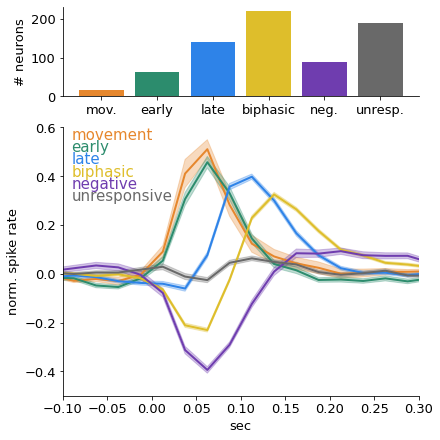

In [175]:
fig = plt.figure(constrained_layout=True, figsize=(6,6))
spec = gridspec.GridSpec(nrows=4, ncols=1, figure=fig)

ax_cluster_sz = fig.add_subplot(spec[0,0])
ax_four_clusters = fig.add_subplot(spec[1:,0])

vcounts = hffm.data['movcluster1'].value_counts()
names = ['movement','early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_cluster_sz.bar(i, vcounts[name], color=hffm.cmap_movclusts[name])
ax_cluster_sz.set_xticks(ticks=range(6), labels=['mov.','early','late','biphasic','neg.','unresp.'])
ax_cluster_sz.set_ylabel('# neurons')

for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster1']==name])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_four_clusters.plot(hffm.trange_x, clustmean, '-', linewidth=2, color=hffm.cmap_movclusts[name])
    ax_four_clusters.fill_between(hffm.trange_x, clustmean-clusterr, clustmean+clusterr, color=hffm.cmap_movclusts[name], alpha=0.3)
ax_four_clusters.set_xlim([-0.1,0.3]); ax_four_clusters.set_ylim([-.5,.6])
ax_four_clusters.annotate('movement', xy=[-0.09,0.55], color=hffm.cmap_movclusts['movement'], fontsize=15)
ax_four_clusters.annotate('early', xy=[-0.09,0.50], color=hffm.cmap_movclusts['early'], fontsize=15)
ax_four_clusters.annotate('late', xy=[-0.09,0.45], color=hffm.cmap_movclusts['late'], fontsize=15)
ax_four_clusters.annotate('biphasic', xy=[-0.09,0.40], color=hffm.cmap_movclusts['biphasic'], fontsize=15)
ax_four_clusters.annotate('negative', xy=[-0.09,0.35], color=hffm.cmap_movclusts['negative'], fontsize=15)
ax_four_clusters.annotate('unresponsive', xy=[-0.09,0.30], color=hffm.cmap_movclusts['unresponsive'], fontsize=15)
ax_four_clusters.set_ylabel('norm. spike rate'); ax_four_clusters.set_xlabel('sec')

fig.savefig('/home/niell_lab/Desktop/fig2.pdf')

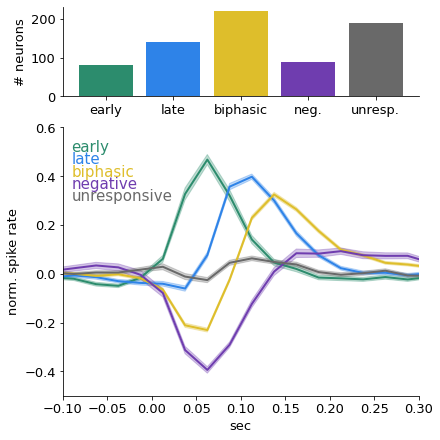

In [207]:
fig = plt.figure(constrained_layout=True, figsize=(6,6))
spec = gridspec.GridSpec(nrows=4, ncols=1, figure=fig)

ax_cluster_sz = fig.add_subplot(spec[0,0])
ax_four_clusters = fig.add_subplot(spec[1:,0])

vcounts = hffm.data['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_cluster_sz.bar(i, vcounts[name], color=hffm.cmap_movclusts[name])
ax_cluster_sz.set_xticks(ticks=range(5), labels=['early','late','biphasic','neg.','unresp.'])
ax_cluster_sz.set_ylabel('# neurons')

for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==name])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_four_clusters.plot(hffm.trange_x, clustmean, '-', linewidth=2, color=hffm.cmap_movclusts[name])
    ax_four_clusters.fill_between(hffm.trange_x, clustmean-clusterr, clustmean+clusterr, color=hffm.cmap_movclusts[name], alpha=0.3)
ax_four_clusters.set_xlim([-0.1,0.3]); ax_four_clusters.set_ylim([-.5,.6])
# ax_four_clusters.annotate('movement', xy=[-0.09,0.55], color=hffm.cmap_movclusts['movement'], fontsize=15)
ax_four_clusters.annotate('early', xy=[-0.09,0.50], color=hffm.cmap_movclusts['early'], fontsize=15)
ax_four_clusters.annotate('late', xy=[-0.09,0.45], color=hffm.cmap_movclusts['late'], fontsize=15)
ax_four_clusters.annotate('biphasic', xy=[-0.09,0.40], color=hffm.cmap_movclusts['biphasic'], fontsize=15)
ax_four_clusters.annotate('negative', xy=[-0.09,0.35], color=hffm.cmap_movclusts['negative'], fontsize=15)
ax_four_clusters.annotate('unresponsive', xy=[-0.09,0.30], color=hffm.cmap_movclusts['unresponsive'], fontsize=15)
ax_four_clusters.set_ylabel('norm. spike rate'); ax_four_clusters.set_xlabel('sec')

fig.savefig('/home/niell_lab/Desktop/four_clusters_no_mov.pdf')

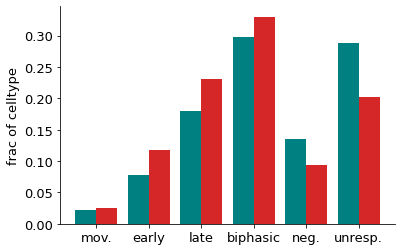

In [176]:
fig, ax = plt.subplots(1,1)
exc_vcounts = hffm.data['movcluster1'][hffm.data['exc_or_inh']=='exc'].value_counts()
inh_vcounts = hffm.data['movcluster1'][hffm.data['exc_or_inh']=='inh'].value_counts()
for i, name in enumerate(['movement','early','late','biphasic','negative','unresponsive']):
    ax.bar(i-0.2, exc_vcounts[name]/exc_vcounts.sum(), color='teal', width=0.4)
    ax.bar(i+0.2, inh_vcounts[name]/inh_vcounts.sum(), color='tab:red', width=0.4)
ax.set_xticks(ticks=range(6), labels=['mov.','early','late','biphasic','neg.','unresp.'])
ax.set_ylabel('frac of celltype')

fig.savefig('/home/niell_lab/Desktop/fig3.pdf')

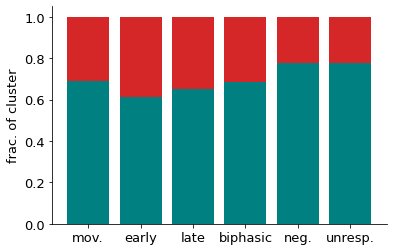

In [177]:
fig, ax = plt.subplots(1,1)
for i, name in enumerate(['movement','early','late','biphasic','negative','unresponsive']):
    vcounts = hffm.data['exc_or_inh'][hffm.data['movcluster1']==name].value_counts()
    ax.bar(i, vcounts['exc']/np.sum(vcounts), color='teal')
    ax.bar(i, vcounts['inh']/np.sum(vcounts), bottom=vcounts['exc']/np.sum(vcounts), color='tab:red')
ax.set_xticks(ticks=range(6), labels=['mov.','early','late','biphasic','neg.','unresp.'])
ax.set_ylabel('frac. of cluster')

fig.savefig('/home/niell_lab/Desktop/fig4.pdf')

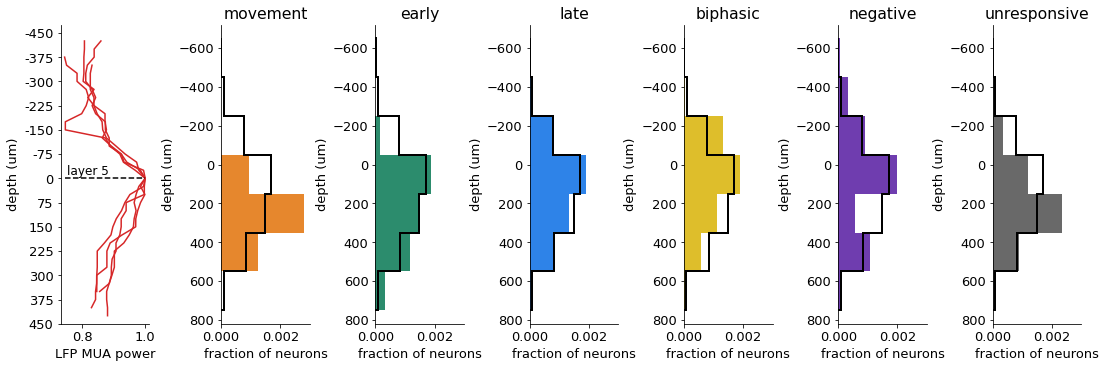

In [178]:
fig = plt.figure(constrained_layout=True, figsize=(15,5))
spec = gridspec.GridSpec(nrows=1, ncols=7, figure=fig)

ax_ex_depth = fig.add_subplot(spec[0,0])
ax_movement_depth = fig.add_subplot(spec[0,1])
ax_early_depth = fig.add_subplot(spec[0,2])
ax_late_depth = fig.add_subplot(spec[0,3])
ax_biphasic_depth = fig.add_subplot(spec[0,4])
ax_negative_depth = fig.add_subplot(spec[0,5])
ax_unresp_depth = fig.add_subplot(spec[0,6])

mua_power = hffm.data['Wn_lfp_power'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]
layer5 = hffm.data['Wn_layer5cent_from_lfp'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]
ch_spacing = 25
for sh in range(4):
    ax_ex_depth.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'tab:red')
# ax_ex_depth.set_title('example recording depth')
ax_ex_depth.hlines(0,np.min(mua_power),np.max(mua_power), 'k', linestyle='dashed')
ax_ex_depth.set_ylim([18,-19])
ax_ex_depth.set_yticks(ticks=np.arange(18,-19,-3), labels=(ch_spacing*np.arange(18,-19,-3)))
ax_ex_depth.set_ylabel('depth (um)'); ax_ex_depth.set_xlabel('LFP MUA power')
ax_ex_depth.annotate('layer 5', xy=[0.75, -.5], color='k', fontsize=12)

panels = [ax_movement_depth, ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth, ax_unresp_depth]
names = ['movement','early','late','biphasic','negative','unresponsive']
for i, panel in enumerate(panels):
    name = names[i]
#     panel.set_title(name)
    panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='step', linewidth=2)
    panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster1']==name],
                        color=hffm.cmap_movclusts[name], bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='stepfilled')
    panel.set_ylabel('depth (um)')
    panel.set_xlabel('fraction of neurons')
    panel.set_title(name)
    panel.invert_yaxis()
    panel.set_xlim(0,0.003)
    
fig.savefig('/home/niell_lab/Desktop/fig5.pdf')

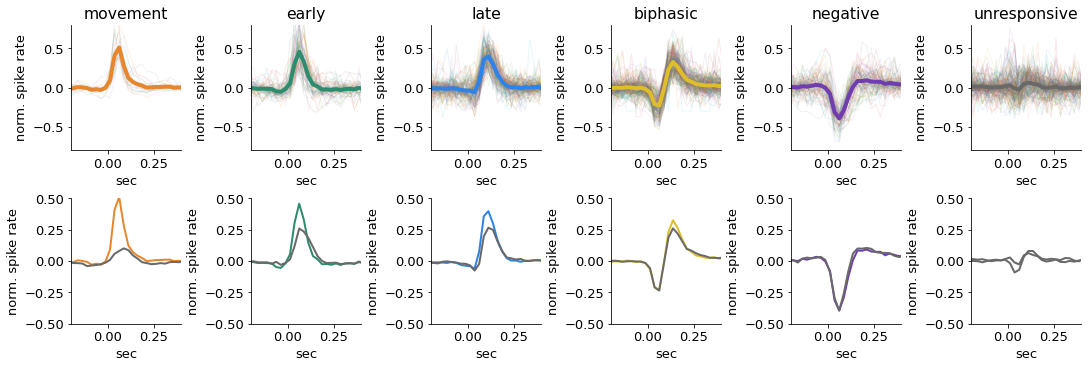

In [230]:
fig = plt.figure(constrained_layout=True, figsize=(15,5))
spec = gridspec.GridSpec(nrows=2, ncols=6, figure=fig)

ax_movement = fig.add_subplot(spec[0,0])
ax_early = fig.add_subplot(spec[0,1])
ax_late = fig.add_subplot(spec[0,2])
ax_biphasic = fig.add_subplot(spec[0,3])
ax_negative = fig.add_subplot(spec[0,4])
ax_unresp = fig.add_subplot(spec[0,5])

ax_movement_pnp = fig.add_subplot(spec[1,0])
ax_early_pnp = fig.add_subplot(spec[1,1])
ax_late_pnp = fig.add_subplot(spec[1,2])
ax_biphasic_pnp = fig.add_subplot(spec[1,3])
ax_negative_pnp = fig.add_subplot(spec[1,4])
ax_unresp_pnp = fig.add_subplot(spec[1,5])

panels = [ax_movement, ax_early, ax_late, ax_biphasic, ax_negative, ax_unresp]
pnp_panels = [ax_movement_pnp, ax_early_pnp, ax_late_pnp, ax_biphasic_pnp, ax_negative_pnp, ax_unresp_pnp]
movtypes = ['movement','early','late','biphasic','negative','unresponsive']
for count in range(6):
    panel = panels[count]
    movtype = movtypes[count]
    pnp_panel = pnp_panels[count]
    
    thisclust = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster1']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(hffm.trange_x, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(hffm.trange_x, clustmean, '-', linewidth=4, color=hffm.cmap_movclusts[movtype])
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])
    panel.set_title(movtype)
    panel.set_ylabel('norm. spike rate'); panel.set_xlabel('sec')
#     panel.vlines(0,-.8,.8, colors='k', linestyle='dotted', alpha=0.3)
    
    gaze_pref = np.nanmean(flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster1']==movtype]),0)
    gaze_nonpref = np.nanmean(flatten_series(hffm.data['nonpref_gazeshift_psth'][hffm.data['movcluster1']==movtype]),0)
    comp_pref = np.nanmean(flatten_series(hffm.data['pref_comp_psth'][hffm.data['movcluster1']==movtype]),0)
    comp_nonpref = np.nanmean(flatten_series(hffm.data['nonpref_comp_psth'][hffm.data['movcluster1']==movtype]),0)
    
    pnp_panel.plot(hffm.trange_x, gaze_pref, '-', linewidth=2, color='tab:blue')
    pnp_panel.plot(hffm.trange_x, gaze_nonpref, '-', linewidth=2, color='lightblue')
    pnp_panel.plot(hffm.trange_x, comp_pref, '-', linewidth=2, color='tab:red')
    pnp_panel.plot(hffm.trange_x, comp_nonpref, '-', linewidth=2, color='lightcoral')
    pnp_panel.set_xlim([-0.2,0.4]); pnp_panel.set_ylim([-.5,.5])
    pnp_panel.set_ylabel('norm. spike rate'); pnp_panel.set_xlabel('sec')
    
fig.savefig('/home/niell_lab/Desktop/fig6.pdf')

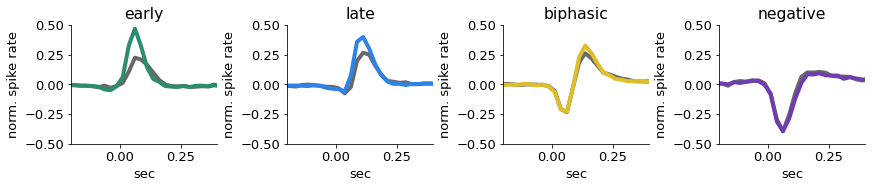

In [238]:
fig = plt.figure(constrained_layout=True, figsize=(12,2.5))
spec = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

ax_early_pnp = fig.add_subplot(spec[0,0])
ax_late_pnp = fig.add_subplot(spec[0,1])
ax_biphasic_pnp = fig.add_subplot(spec[0,2])
ax_negative_pnp = fig.add_subplot(spec[0,3])

pnp_panels = [ax_early_pnp, ax_late_pnp, ax_biphasic_pnp, ax_negative_pnp]
movtypes = ['early','late','biphasic','negative']
for count in range(4):
    movtype = movtypes[count]
    pnp_panel = pnp_panels[count]
    
    thisclust = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype]
    
    gaze_pref = np.nanmean(flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype]),0)
    gaze_nonpref = np.nanmean(flatten_series(hffm.data['nonpref_gazeshift_psth'][hffm.data['movcluster']==movtype]),0)
#     comp_pref = np.nanmean(flatten_series(hffm.data['pref_comp_psth'][hffm.data['movcluster1']==movtype]),0)
#     comp_nonpref = np.nanmean(flatten_series(hffm.data['nonpref_comp_psth'][hffm.data['movcluster1']==movtype]),0)
    
    pnp_panel.plot(hffm.trange_x, gaze_nonpref, '-', linewidth=4, color='dimgray')
    pnp_panel.plot(hffm.trange_x, gaze_pref, '-', linewidth=4, color=hffm.cmap_movclusts[movtype])
    
#     pnp_panel.plot(hffm.trange_x, comp_pref, '-', linewidth=2, color='tab:red')
#     pnp_panel.plot(hffm.trange_x, comp_nonpref, '-', linewidth=2, color='lightcoral')
    pnp_panel.set_xlim([-0.2,0.4]); pnp_panel.set_ylim([-.5,.5])
    pnp_panel.set_ylabel('norm. spike rate'); pnp_panel.set_xlabel('sec')
    pnp_panel.set_title(movtype)

fig.savefig('/home/niell_lab/Desktop/fig6A.pdf')

array([-1.        , -0.85714286, -0.71428571, -0.57142857, -0.42857143,
       -0.28571429, -0.14285714,  0.        ,  0.14285714,  0.28571429,
        0.42857143,  0.57142857,  0.71428571,  0.85714286,  1.        ])

Text(0.5, 1.0, 'early cluster')

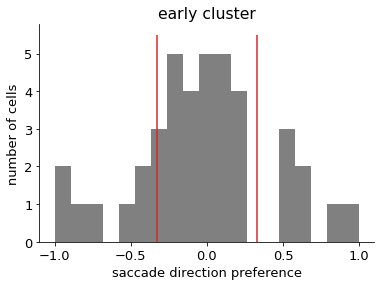

In [256]:
plt.hist(hffm.data['gaze_sacc_rlMI'][hffm.data['movcluster']=='early'], bins=np.linspace(-1,1,20), color='grey')
plt.vlines(0.33, 0, 5.5, 'tab:red')
plt.vlines(-0.33, 0, 5.5, 'tab:red')
plt.xlabel('saccade direction preference')
plt.ylabel('number of cells')
plt.title('early cluster')

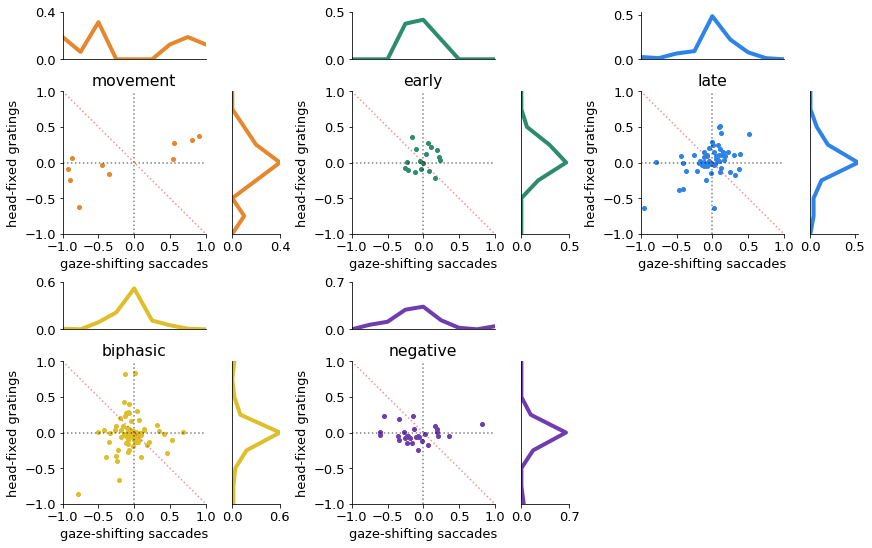

In [227]:
fig = plt.figure(constrained_layout=True, figsize=(12,7.5))
spec = gridspec.GridSpec(nrows=8, ncols=12, figure=fig)

ax_movement_xh = fig.add_subplot(spec[0,0:3])
ax_movement_yh = fig.add_subplot(spec[1:4,3])
ax_movement = fig.add_subplot(spec[1:4,0:3])
movement_panels = [ax_movement_xh, ax_movement_yh, ax_movement]

ax_early_xh = fig.add_subplot(spec[0,4:7])
ax_early_yh = fig.add_subplot(spec[1:4,7])
ax_early = fig.add_subplot(spec[1:4,4:7])
early_panels = [ax_early_xh, ax_early_yh, ax_early]

ax_late_xh = fig.add_subplot(spec[0,8:11])
ax_late_yh = fig.add_subplot(spec[1:4,11])
ax_late = fig.add_subplot(spec[1:4,8:11])
late_panels = [ax_late_xh, ax_late_yh, ax_late]

ax_biphasic_xh = fig.add_subplot(spec[4,0:3])
ax_biphasic_yh = fig.add_subplot(spec[5:8,3])
ax_biphasic = fig.add_subplot(spec[5:8,0:3])
biphasic_panels = [ax_biphasic_xh, ax_biphasic_yh, ax_biphasic]

ax_negative_xh = fig.add_subplot(spec[4,4:7])
ax_negative_yh = fig.add_subplot(spec[5:8,7])
ax_negative = fig.add_subplot(spec[5:8,4:7])
negative_panels = [ax_negative_xh, ax_negative_yh, ax_negative]

panels = [movement_panels, early_panels, late_panels, biphasic_panels, negative_panels]
for i, name in enumerate(['movement','early','late','biphasic','negative']):
    ax_xhist, ax_yhist, ax_scatter = panels[i]

    ax_scatter.plot(hffm.data['gaze_sacc_rlMI'][hffm.data['movcluster1']==name], hffm.data['gratings_rlMI'][hffm.data['movcluster1']==name], '.', color=hffm.cmap_movclusts[name], markersize=8)
    ax_scatter.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    ax_scatter.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    ax_scatter.set_title(name)
    ax_scatter.set_ylabel('head-fixed gratings')
    ax_scatter.set_xlabel('gaze-shifting saccades')
#     ax_LR_gaze_grat.set_xlim([-1,1]); ax_LR_gaze_grat.set_ylim([-1,1])
    ax_scatter.plot([-1,1], [1,-1], linestyle='dotted', alpha=0.5, color='tab:red')
    ax_scatter.set_yticks(np.arange(-1,1.5,0.5)); ax_scatter.set_xticks(np.arange(-1,1.5,0.5))
    ax_scatter.set_xlim([-1,1]); ax_scatter.set_ylim([-1,1])
    
    ydata = hffm.data['gratings_rlMI'][hffm.data['movcluster1']==name]
    yhist, edges = np.histogram(ydata[~np.isnan(ydata)], np.linspace(-1,1,10))
    yhist = yhist/np.sum(yhist)
    ax_yhist.plot(yhist, np.linspace(-1,1,9), color=hffm.cmap_movclusts[name], linewidth=4)
    ax_yhist.set_yticks([]); ax_yhist.set_ylim([-1,1])
    
    xdata = hffm.data['gaze_sacc_rlMI'][hffm.data['movcluster1']==name]
    xhist, edges = np.histogram(xdata[~np.isnan(xdata)], np.linspace(-1,1,10))
    xhist = xhist/np.sum(xhist)
    ax_xhist.plot(np.linspace(-1,1,9), xhist, color=hffm.cmap_movclusts[name], linewidth=4)
    ax_xhist.set_xticks([]); ax_xhist.set_xlim([-1,1])
    
    histmax = np.max([xhist, yhist])
    ax_xhist.set_ylim([0,histmax]); ax_xhist.set_yticks([0, np.round(histmax, 1)])
    ax_yhist.set_xlim([0,histmax]); ax_yhist.set_xticks([0, np.round(histmax, 1)])
    
fig.savefig('/home/niell_lab/Desktop/fig7.pdf')

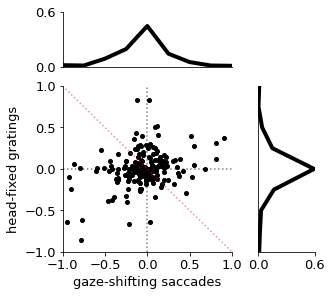

In [111]:
fig = plt.figure(constrained_layout=True, figsize=(4.5,4))
spec = gridspec.GridSpec(nrows=4, ncols=4, figure=fig)

ax_xhist = fig.add_subplot(spec[0,0:3])
ax_yhist = fig.add_subplot(spec[1:4,3])
ax_scatter = fig.add_subplot(spec[1:4,0:3])

ax_scatter.plot(hffm.data['gaze_sacc_rlMI'], hffm.data['gratings_rlMI'], '.', color='k', markersize=8)
ax_scatter.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
ax_scatter.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
# ax_scatter.set_title(name)
ax_scatter.set_ylabel('head-fixed gratings')
ax_scatter.set_xlabel('gaze-shifting saccades')
#     ax_LR_gaze_grat.set_xlim([-1,1]); ax_LR_gaze_grat.set_ylim([-1,1])
ax_scatter.plot([-1,1], [1,-1], linestyle='dotted', alpha=0.5, color='tab:red')
ax_scatter.set_yticks(np.arange(-1,1.5,0.5)); ax_scatter.set_xticks(np.arange(-1,1.5,0.5))
ax_scatter.set_xlim([-1,1]); ax_scatter.set_ylim([-1,1])

ydata = hffm.data['gratings_rlMI']
yhist, edges = np.histogram(ydata[~np.isnan(ydata)], np.linspace(-1,1,10))
yhist = yhist/np.sum(yhist)
ax_yhist.plot(yhist, np.linspace(-1,1,9), color='k', linewidth=4)
ax_yhist.set_yticks([]); ax_yhist.set_ylim([-1,1])

xdata = hffm.data['gaze_sacc_rlMI']
xhist, edges = np.histogram(xdata[~np.isnan(xdata)], np.linspace(-1,1,10))
xhist = xhist/np.sum(xhist)
ax_xhist.plot(np.linspace(-1,1,9), xhist, color='k', linewidth=4)
ax_xhist.set_xticks([]); ax_xhist.set_xlim([-1,1])

histmax = np.max([xhist, yhist])
ax_xhist.set_ylim([0,histmax]); ax_xhist.set_yticks([0, np.round(histmax, 1)])
ax_yhist.set_xlim([0,histmax]); ax_yhist.set_xticks([0, np.round(histmax, 1)])

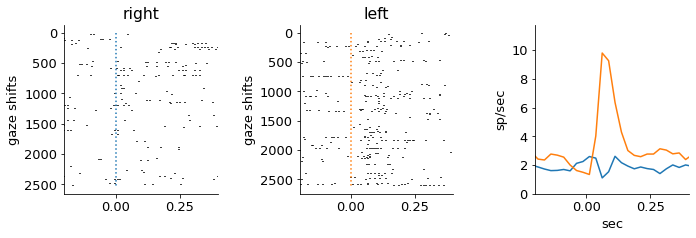

In [15]:
fig, axs = plt.subplots(1,3,figsize=(10,3.5))

u1 = 151 # positive response to left

deye = hffm.data.loc[u1, 'FmLt_dEye_dps']
eyeT = hffm.data.loc[u1, 'FmLt_eyeT']
dgaze = hffm.data.loc[u1, 'FmLt_dGaze']
sthresh = 5/0.016

right = eyeT[(np.append(deye, 0) > sthresh) & (np.append(dgaze,0) > sthresh)]
left = eyeT[(np.append(deye, 0) < -sthresh) & (np.append(dgaze,0) < -sthresh)]

ax_u1_dEye_raster = plt.subplot(131)

sp = np.array(hffm.data.loc[u1,'FmLt_spikeT'])
ns = np.zeros(len(left)+1)
for n, s in enumerate(left):
    sd = np.abs(sp-np.array(s))<1
    sacc_sp = sp[sd]
    ns = len(sacc_sp)
    ax_u1_dEye_raster.vlines(sacc_sp-np.array(s), n-0.5, n+0.5, color='k')
ax_u1_dEye_raster.set_xlim([-0.2,0.4])
ax_u1_dEye_raster.vlines(0, 0, len(left), linestyles='dotted', color='tab:blue')
ax_u1_dEye_raster.invert_yaxis()
ax_u1_dEye_raster.set_ylabel('gaze shifts')
ax_u1_dEye_raster.set_title('right')

ax_u1_dEye_raster_left = plt.subplot(132)

sp = np.array(hffm.data.loc[u1,'FmLt_spikeT'])
ns = np.zeros(len(left)+1)
for n, s in enumerate(right):
    sd = np.abs(sp-np.array(s))<1
    sacc_sp = sp[sd]
    ns = len(sacc_sp)
    ax_u1_dEye_raster_left.vlines(sacc_sp-np.array(s), n-0.5, n+0.5, color='k')
ax_u1_dEye_raster_left.set_xlim([-0.2,0.4])
ax_u1_dEye_raster_left.vlines(0, 0, len(right), linestyles='dotted', color='tab:orange')
ax_u1_dEye_raster_left.invert_yaxis()
ax_u1_dEye_raster_left.set_ylabel('gaze shifts')
ax_u1_dEye_raster_left.set_title('left')

ax_u1_dEye_psth = plt.subplot(133)

rightavg = hffm.data.loc[u1, 'FmLt_rightsacc_avg_gaze_shift_dEye']
leftavg = hffm.data.loc[u1, 'FmLt_leftsacc_avg_gaze_shift_dEye']
ax_u1_dEye_psth.plot(hffm.trange_x, rightavg, color='tab:blue')
ax_u1_dEye_psth.plot(hffm.trange_x, leftavg, color='tab:orange')
maxval = np.max(np.maximum(rightavg, leftavg))*1.2
ax_u1_dEye_psth.set_ylim([0, maxval])
ax_u1_dEye_psth.set_xlim([-0.2,0.4])
# ax_u1_dEye_psth.set_title('unit 1')
ax_u1_dEye_psth.set_ylabel('sp/sec')
ax_u1_dEye_psth.set_xlabel('sec')
# ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal')
# ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray')

plt.tight_layout()

In [86]:
for ind, row in hffm.data.iterrows():
    tf = 2 + (6 * (row['tf_pref']-1))
    sf = 0.02 * 4 ** (row['sf_pref']-1)
    hffm.data.at[ind, 'tf_pref_cps'] = tf
    hffm.data.at[ind, 'sf_pref_cpd'] = sf
    hffm.data.at[ind, 'grat_speed_dps'] = tf / sf

In [183]:
def plot_cprop_scatter(panel, prop_name, filter_by=[], row=None):
    
    for c, cluster in enumerate(['movement','early','late','biphasic','negative','unresponsive']):
        if filter_by:
            for filt in filter_by:
                data = hffm.data[hffm.data[filt]==True]
        else:
            data = hffm.data.copy()
        data = data[prop_name][data['movcluster1']==cluster]
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
        panel.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[cluster])
        panel.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
        panel.set_xticks(range(6), ['mov.','early','late','biph.','neg.','uresp.'])
    if row is not None:
        panel.plot(cluster_names.index(row['movcluster1']), row[prop_name], '*', color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

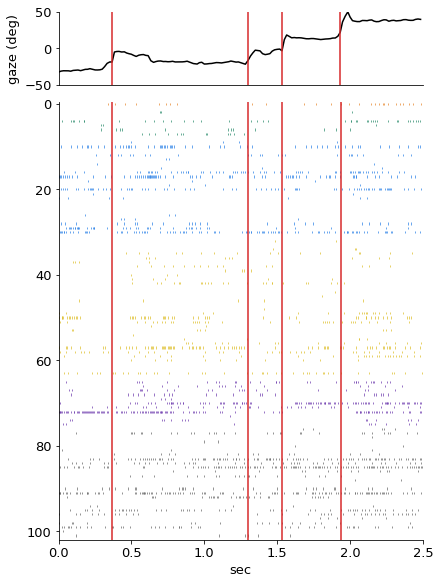

In [184]:
rec = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2']
start = 420 # frames, not sec
win = int(60*2.5) # frames, not sec
twin = 2.5 # sec

fig = plt.figure(constrained_layout=True, figsize=(6,8))
spec = gridspec.GridSpec(nrows=14, ncols=1, figure=fig)

ax_gaze = fig.add_subplot(spec[0:2,0])
ax_raster = fig.add_subplot(spec[2:,0])

eyeT = rec['FmLt_eyeT'].iloc[0]
dEye = rec['FmLt_dEye_dps'].iloc[0]
dGaze = rec['FmLt_dGaze'].iloc[0]

tstart = eyeT[start] # sec

theta = rec['FmLt_theta'].iloc[0][start:start+win]
theta = theta - np.nanmean(theta)
dHead = rec['FmLt_dHead'].iloc[0][start:start+win]
pYaw = np.nancumsum(dHead*0.016)
pYaw = pYaw - np.nanmean(pYaw)
gaze = theta + pYaw

sthresh = 5/.016
right = eyeT[(np.append(dEye, 0) > sthresh) & (np.append(dGaze,0) > sthresh)]
left = eyeT[(np.append(dEye, 0) < -sthresh) & (np.append(dGaze,0) < -sthresh)]

ax_gaze.plot(eyeT[start:start+win], gaze, color='k')
ax_gaze.set_xlim([eyeT[start], eyeT[start+win]])
ax_gaze.set_ylim([-50,50])
ax_gaze.set_xticks([])
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.vlines(right, -50, 50, color='tab:red')
ax_gaze.vlines(left, -50, 50, color='tab:red')

i = 0
for c, name in enumerate(['movement','early','late','biphasic','negative','unresponsive']):
    cunits = rec['FmLt_spikeT'][rec['movcluster1']==name]
    for spikeT in cunits:
        spikeT = spikeT[(spikeT>tstart) * (spikeT<(tstart+twin))]
        ax_raster.vlines(spikeT, i-0.25, i+0.25, color=hffm.cmap_movclusts[name], linewidth=0.7)
        i += 1
ax_raster.set_ylim([len(rec.index.values), -0.5])
ax_raster.set_xlim([tstart, tstart+twin])
ax_raster.set_xticks(np.linspace(tstart, tstart+twin, 6), np.linspace(0, 2.5, 6))
ax_raster.set_xlabel('sec')
ax_raster.vlines(right, -0.5, 102, color='tab:red')
ax_raster.vlines(left, -0.5, 102, color='tab:red')

fig.savefig('/home/niell_lab/Desktop/raster_by_celltype.pdf')

# Head-fixed contrast

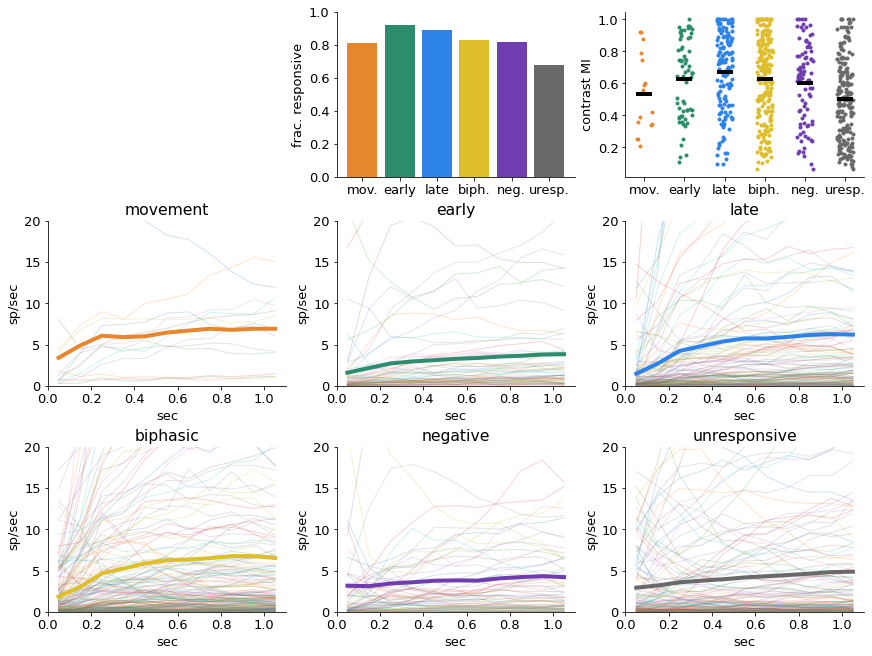

In [185]:
fig = plt.figure(constrained_layout=True, figsize=(12,9))
spec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig)

ax_frac_resp = fig.add_subplot(spec[0,1])
ax_cmi = fig.add_subplot(spec[0,2])

ax_crf_movement = fig.add_subplot(spec[1,0])
ax_crf_early = fig.add_subplot(spec[1,1])
ax_crf_late = fig.add_subplot(spec[1,2])
ax_crf_biphasic = fig.add_subplot(spec[2,0])
ax_crf_negative = fig.add_subplot(spec[2,1])
ax_crf_unresp = fig.add_subplot(spec[2,2])

cluster_names = ['movement','early','late','biphasic','negative','unresponsive']

cluster_vcounts = hffm.data['movcluster1'].value_counts()
contrast_cluster_vcounts = hffm.data['movcluster1'][hffm.data['responsive_to_contrast']].value_counts()
for i, name in enumerate(cluster_names):
    ax_frac_resp.bar(i, contrast_cluster_vcounts[name]/cluster_vcounts[name], color=hffm.cmap_movclusts[name])
ax_frac_resp.set_xticks(ticks=range(6), labels=['mov.','early','late','biph.','neg.','uresp.'])
ax_frac_resp.set_ylabel('frac. responsive')
ax_frac_resp.set_ylim([0,1])

plot_cprop_scatter(ax_cmi, 'Wn_contrast_modind')
ax_cmi.set_ylabel('contrast MI')

crf_panels = [ax_crf_movement,ax_crf_early,ax_crf_late,ax_crf_biphasic,ax_crf_negative,ax_crf_unresp]
crf_bins = hffm.data.loc[0, 'Wn_contrast_tuning_bins']
for i, name in enumerate(cluster_names):
    avg_crf = flatten_series(hffm.data['Wn_contrast_tuning'][hffm.data['movcluster1']==name][hffm.data['responsive_to_contrast']==True])
    
    panel = crf_panels[i]
    panel.set_title(name)
    for psth in hffm.data['Wn_contrast_tuning'][hffm.data['movcluster1']==name][hffm.data['responsive_to_contrast']==True]:
        panel.plot(crf_bins, psth, alpha=0.2, linewidth=1)
    panel.plot(crf_bins, np.nanmean(avg_crf, 0), color=hffm.cmap_movclusts[name], linewidth=4)
    panel.set_ylabel('sp/sec'); panel.set_xlabel('sec')
    panel.set_ylim([0,20])

fig.savefig('/home/niell_lab/Desktop/contrast.pdf')

# Gratings

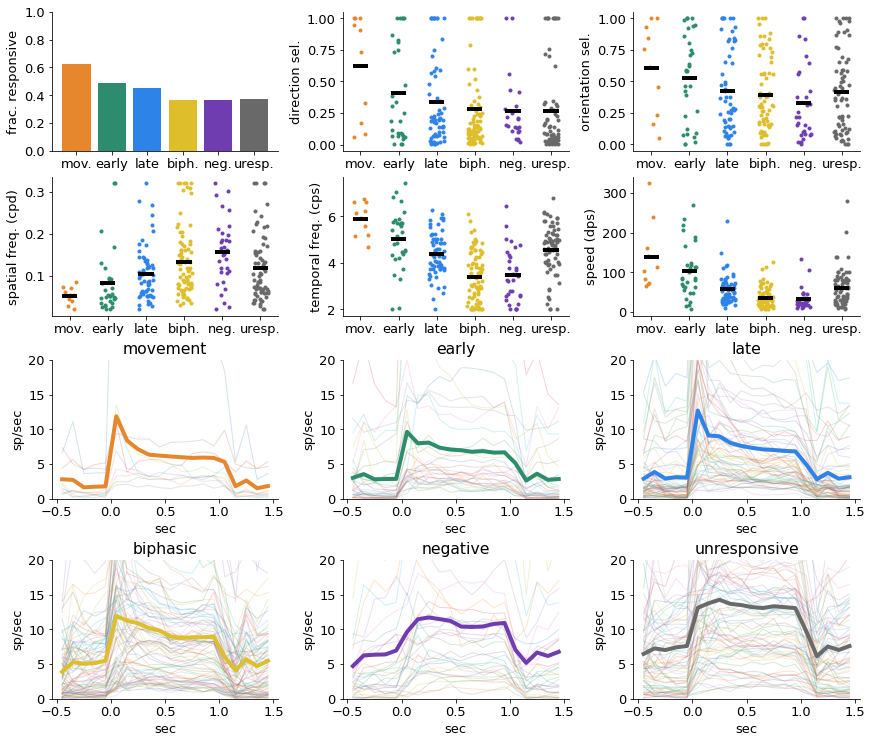

In [186]:
fig = plt.figure(constrained_layout=True, figsize=(12,16))
spec = gridspec.GridSpec(nrows=7, ncols=3, figure=fig)

ax_gratings_frac = fig.add_subplot(spec[0,0])
ax_dsi = fig.add_subplot(spec[0,1])
ax_osi = fig.add_subplot(spec[0,2])

ax_sf = fig.add_subplot(spec[1,0])
ax_tf = fig.add_subplot(spec[1,1])
ax_speed = fig.add_subplot(spec[1,2])

ax_GtPsth_movement = fig.add_subplot(spec[2,0])
ax_GtPsth_early = fig.add_subplot(spec[2,1])
ax_GtPsth_late = fig.add_subplot(spec[2,2])
ax_GtPsth_biphasic = fig.add_subplot(spec[3,0])
ax_GtPsth_negative = fig.add_subplot(spec[3,1])
ax_GtPsth_unresp = fig.add_subplot(spec[3,2])

cluster_vcounts = hffm.data['movcluster1'].value_counts()
contrast_cluster_vcounts = hffm.data['movcluster1'][hffm.data['responsive_to_gratings']].value_counts()
for i, name in enumerate(cluster_names):
    ax_gratings_frac.bar(i, contrast_cluster_vcounts[name]/cluster_vcounts[name], color=hffm.cmap_movclusts[name])
ax_gratings_frac.set_xticks(ticks=range(6), labels=['mov.','early','late','biph.','neg.','uresp.'])
ax_gratings_frac.set_ylabel('frac. responsive')
ax_gratings_frac.set_ylim([0,1])

plot_cprop_scatter(ax_dsi, 'dsi_for_sf_pref', filter_by=['responsive_to_gratings'])
ax_dsi.set_ylabel('direction sel.')

plot_cprop_scatter(ax_osi, 'osi_for_sf_pref', filter_by=['responsive_to_gratings'])
ax_osi.set_ylabel('orientation sel.')

plot_cprop_scatter(ax_sf, 'sf_pref_cpd', filter_by=['responsive_to_gratings'])
ax_sf.set_ylabel('spatial freq. (cpd)')

plot_cprop_scatter(ax_tf, 'tf_pref_cps', filter_by=['responsive_to_gratings'])
ax_tf.set_ylabel('temporal freq. (cps)')

plot_cprop_scatter(ax_speed, 'grat_speed_dps', filter_by=['responsive_to_gratings'])
ax_speed.set_ylabel('speed (dps)')

crf_panels = [ax_GtPsth_movement,ax_GtPsth_early,ax_GtPsth_late,ax_GtPsth_biphasic,ax_GtPsth_negative,ax_GtPsth_unresp]
for i, name in enumerate(cluster_names):
    avg_crf = flatten_series(hffm.data['Gt_grating_psth'][hffm.data['movcluster1']==name][hffm.data['responsive_to_gratings']==True])
    panel = crf_panels[i]
    panel.set_title(name)
    for psth in hffm.data['Gt_grating_psth'][hffm.data['movcluster1']==name][hffm.data['responsive_to_gratings']==True]:
        panel.plot(hffm.grat_psth_x, psth, alpha=0.2, linewidth=1)
    panel.plot(hffm.grat_psth_x, np.nanmean(avg_crf, 0), color=hffm.cmap_movclusts[name], linewidth=4)
    panel.set_ylabel('sp/sec'); panel.set_xlabel('sec')
    panel.set_ylim([0,20])
    
fig.savefig('/home/niell_lab/Desktop/gratings.pdf')

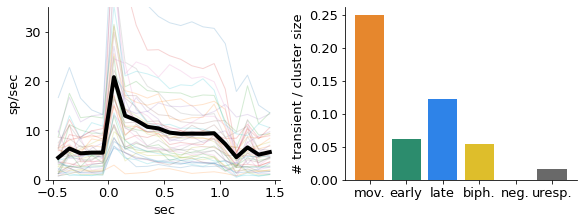

In [187]:
fig = plt.figure(constrained_layout=True, figsize=(8,3))
spec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

ax_trpsth = fig.add_subplot(spec[0,0])
ax_tr_fracs = fig.add_subplot(spec[0,1])

trPsth = hffm.data[hffm.data['is_grat_trpsth']][hffm.data['responsive_to_gratings']]
sPsth = hffm.data[hffm.data['responsive_to_gratings']][hffm.data['is_grat_trpsth']==False]
for ind, psth in trPsth['Gt_grating_psth'].iteritems():
    ax_trpsth.plot(hffm.grat_psth_x, psth, alpha=.2, linewidth=1)
this_mean = np.nanmean(flatten_series(trPsth['Gt_grating_psth']),0)
ax_trpsth.plot(hffm.grat_psth_x, this_mean, color='k', linewidth=4)
ax_trpsth.set_ylim([0,35]); ax_trpsth.set_ylabel('sp/sec'); ax_trpsth.set_xlabel('sec')

SbC_vcounts = trPsth['movcluster1'].value_counts()
names = ['movement','early','late','biphasic','negative','unresponsive']
for n in names:
    if n not in SbC_vcounts.index.values:
        SbC_vcounts[n] = 0
for x, name in enumerate(names):
    ax_tr_fracs.bar(x, SbC_vcounts[name]/len(hffm.data[hffm.data['movcluster1']==name]), color=hffm.cmap_movclusts[name])
ax_tr_fracs.set_xticks(ticks=range(6), labels=['mov.','early','late','biph.','neg.','uresp.'])
ax_tr_fracs.set_ylabel('# transient / cluster size')

fig.savefig('/home/niell_lab/Desktop/transient_gratings.pdf')

# SbC

In [12]:
model_dt = 0.025
for ind, row in hffm.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    hffm.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    hffm.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['Wn_eyeT']), model_dt)
    diff = len(modelT) - len(row['Wn_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    ballT = np.linspace(row['Wn_eyeT'][0], row['Wn_eyeT'][-1], row['Wn_ballspeed'].values.shape[0])
    model_speed = interp1d(ballT, row['Wn_ballspeed'].values, bounds_error=False)(modelT)
    hffm.data.at[ind, 'Wn_modelT'] = modelT.astype(object)
    hffm.data.at[ind, 'Wn_ball_speed'] = model_speed.astype(object)

In [13]:
for ind, row in hffm.data.iterrows():
    hffm.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    hffm.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    hffm.data.at[ind,'Wn_active_fr'] = (np.sum(row['Wn_rate'][row['Wn_ball_speed']>=1.0])) / np.size(row['Wn_modelT'][row['Wn_ball_speed']>=1.0])
    hffm.data.at[ind,'Wn_inactive_fr'] = (np.sum(row['Wn_rate'][row['Wn_ball_speed']<1.0])) / np.size(row['Wn_modelT'][row['Wn_ball_speed']<1.0])

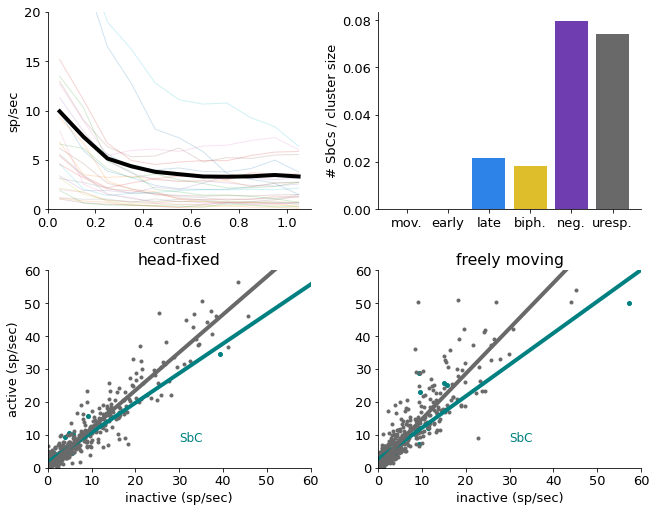

In [190]:
fig = plt.figure(constrained_layout=True, figsize=(9,7))
spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

ax_sbc_psths = fig.add_subplot(spec[0,0])
ax_sbc_frac = fig.add_subplot(spec[0,1])
ax_hf_gain = fig.add_subplot(spec[1,0])
ax_fm_gain = fig.add_subplot(spec[1,1])

SBCs = hffm.data[hffm.data['is_SbC']]
    
for ind, row in SBCs.iterrows():
    ax_sbc_psths.plot(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], linewidth=1, alpha=0.2)
this_mean = np.nanmean(flatten_series(SBCs['Wn_contrast_tuning']),0)
ax_sbc_psths.plot(row['Wn_contrast_tuning_bins'], this_mean, color='k', linewidth=4)
ax_sbc_psths.set_ylim([0,20])
ax_sbc_psths.set_ylabel('sp/sec'); ax_sbc_psths.set_xlabel('contrast')

cluster_vcounts = hffm.data['movcluster1'].value_counts()
contrast_cluster_vcounts = SBCs['movcluster1'][SBCs['responsive_to_contrast']].value_counts()
for i, name in enumerate(cluster_names):
    if name not in contrast_cluster_vcounts:
        contrast_cluster_vcounts[name] = 0
    ax_sbc_frac.bar(i, contrast_cluster_vcounts[name]/cluster_vcounts[name], color=hffm.cmap_movclusts[name])
ax_sbc_frac.set_xticks(ticks=range(6), labels=['mov.','early','late','biph.','neg.','uresp.'])
ax_sbc_frac.set_ylabel('# SbCs / cluster size')


ax_hf_gain.plot(hffm.data['Wn_inactive_fr'][hffm.data['is_SbC']==True], hffm.data['Wn_active_fr'][hffm.data['is_SbC']==True], '.', color='teal', markersize=8)
ax_hf_gain.plot(hffm.data['Wn_inactive_fr'][hffm.data['is_SbC']==False], hffm.data['Wn_active_fr'][hffm.data['is_SbC']==False], '.', color='dimgrey')
fit_sbc = linregress(hffm.data['Wn_inactive_fr'][hffm.data['is_SbC']==True], hffm.data['Wn_active_fr'][hffm.data['is_SbC']==True])
fit_notsbc = linregress(hffm.data['Wn_inactive_fr'][hffm.data['is_SbC']==False], hffm.data['Wn_active_fr'][hffm.data['is_SbC']==False])
ax_hf_gain.plot([0,60],[fit_sbc.intercept, (60*fit_sbc.slope)+fit_sbc.intercept], linewidth=4, color='teal')
ax_hf_gain.plot([0,60],[fit_notsbc.intercept, (60*fit_notsbc.slope)+fit_notsbc.intercept], linewidth=4, color='dimgrey')
ax_hf_gain.set_xlabel('inactive (sp/sec)'); ax_hf_gain.set_ylabel('active (sp/sec)')
ax_hf_gain.annotate('SbC', xy=[30,8], color='teal', fontsize=12)
ax_hf_gain.set_xlim([0,60]); ax_hf_gain.set_ylim([0,60])
# ax_hf_gain.set_xticks(np.linspace(0,40,5)); ax_active_fr.set_yticks(np.linspace(0,40,5))
ax_hf_gain.set_title('head-fixed')

ax_fm_gain.plot(hffm.data['FmLt_inactive_fr'][hffm.data['is_SbC']==True], hffm.data['FmLt_active_fr'][hffm.data['is_SbC']==True], '.', color='teal', markersize=8)
ax_fm_gain.plot(hffm.data['FmLt_inactive_fr'][hffm.data['is_SbC']==False], hffm.data['FmLt_active_fr'][hffm.data['is_SbC']==False], '.', color='dimgrey')
fit_sbc = linregress(hffm.data['FmLt_inactive_fr'][hffm.data['is_SbC']==True], hffm.data['FmLt_active_fr'][hffm.data['is_SbC']==True])
fit_notsbc = linregress(hffm.data['FmLt_inactive_fr'][hffm.data['is_SbC']==False], hffm.data['FmLt_active_fr'][hffm.data['is_SbC']==False])
ax_fm_gain.plot([0,60],[fit_sbc.intercept, (60*fit_sbc.slope)+fit_sbc.intercept], linewidth=4, color='teal')
ax_fm_gain.plot([0,60],[fit_notsbc.intercept, (60*fit_notsbc.slope)+fit_notsbc.intercept], linewidth=4, color='dimgrey')
ax_fm_gain.set_xlabel('inactive (sp/sec)'); ax_hf_gain.set_ylabel('active (sp/sec)')
ax_fm_gain.annotate('SbC', xy=[30,8], color='teal', fontsize=12)
ax_fm_gain.set_xlim([0,60]); ax_fm_gain.set_ylim([0,60])
# ax_fm_gain.set_xticks(np.linspace(0,40,5)); ax_fm_gain.set_yticks(np.linspace(0,40,5))
ax_fm_gain.set_title('freely moving')

fig.savefig('/home/niell_lab/Desktop/sbc.pdf')

# Dark

In [14]:
model_dt = 0.025
for ind, row in ltdk.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [15]:
ltdk.data['FmLt_fr'] = ((ltdk.data['FmLt_rate'].apply(np.sum)*0.025) / ltdk.data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
ltdk.data['FmDk_fr'] = ((ltdk.data['FmDk_rate'].apply(np.sum)*0.025) / ltdk.data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [16]:
FmLt_fr = np.zeros([len(ltdk.data.index.values)])
FmDk_fr = np.zeros([len(ltdk.data.index.values)])
for ind, row in ltdk.data.iterrows():
    ltdk.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    ltdk.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    ltdk.data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    ltdk.data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

Text(0.5, 1.0, 'negative')

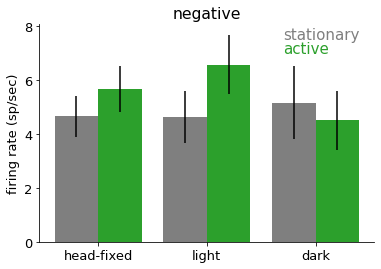

In [45]:
colors = ['tab:grey', 'tab:green']
shift = [0.3,-0.3]
clust = 'negative'

for i, name in enumerate(['Wn_inactive_fr', 'Wn_active_fr']):
    data = hffm.data[name][hffm.data['movcluster1']==clust].to_numpy()
    mean = np.nanmean(data)
    err = np.std(data, 0) / np.sqrt(np.size(data,0))
    plt.bar((i)+shift[i], mean, yerr=err, color=colors[i], width=0.4)
    
for i, name in enumerate(['FmLt_inactive_fr', 'FmLt_active_fr']):
    data = hffm.data[name][hffm.data['movcluster1']==clust].to_numpy()
    mean = np.nanmean(data)
    err = np.std(data, 0) / np.sqrt(np.size(data,0))
    plt.bar((1+i)+shift[i], mean, yerr=err, color=colors[i], width=0.4)

for i, name in enumerate(['FmDk_inactive_fr', 'FmDk_active_fr']):
    data = ltdk.data[name][hffm.data['movcluster1']==clust].to_numpy()
    mean = np.nanmean(data)
    err = np.std(data, 0) / np.sqrt(np.size(data,0))
    plt.bar((2+i)+shift[i], mean, yerr=err, color=colors[i], width=0.4)

plt.xticks(np.linspace(0.5,2.5,3), labels=['head-fixed','light','dark'])
plt.ylabel('firing rate (sp/sec)')
plt.annotate('stationary', xy=[2.2,7.5], color='tab:grey', fontsize=15)
plt.annotate('active', xy=[2.2,7], color='tab:green', fontsize=15)
plt.title(clust)

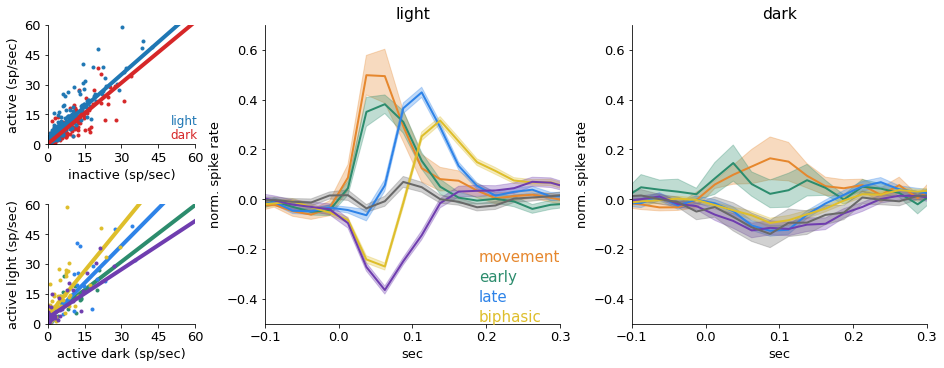

In [194]:
cluster_names = ['movement','early','late','biphasic','negative','unresponsive']

fig = plt.figure(constrained_layout=True, figsize=(13,5))
spec = gridspec.GridSpec(nrows=2, ncols=5, figure=fig)

ax_active_fr = ax_early = fig.add_subplot(spec[0,0])
ax_cluster_fr = ax_early = fig.add_subplot(spec[1,0])

ax_light_summary = fig.add_subplot(spec[0:2,1:3])
ax_dark_summary = fig.add_subplot(spec[0:2,3:5])

ax_active_fr.plot(ltdk.data['FmDk_inactive_fr'], ltdk.data['FmDk_active_fr'], '.', color='tab:red')
ax_active_fr.plot(ltdk.data['FmLt_inactive_fr'], ltdk.data['FmLt_active_fr'], '.', color='tab:blue')
fit_dark = linregress(ltdk.data['FmDk_inactive_fr'], ltdk.data['FmDk_active_fr'])
fit_light = linregress(ltdk.data['FmLt_inactive_fr'], ltdk.data['FmLt_active_fr'])
ax_active_fr.plot([0,60],[fit_light.intercept, (60*fit_light.slope)+fit_light.intercept], linewidth=4, color='tab:blue')
ax_active_fr.plot([0,60],[fit_dark.intercept, (60*fit_dark.slope)+fit_dark.intercept], linewidth=4, color='tab:red')
ax_active_fr.set_xlabel('inactive (sp/sec)'); ax_active_fr.set_ylabel('active (sp/sec)')
ax_active_fr.annotate('light', xy=[50,10], color='tab:blue', fontsize=12)
ax_active_fr.annotate('dark', xy=[50,3], color='tab:red', fontsize=12)
ax_active_fr.set_xlim([0,60]); ax_active_fr.set_ylim([0,60])
ax_active_fr.set_xticks(np.linspace(0,60,5)); ax_active_fr.set_yticks(np.linspace(0,60,5))

for c, name in enumerate(cluster_names[:-1]):
    data = ltdk.data[ltdk.data['movcluster']==name]
    if len(data.index.values) == 0:
        continue
    ax_cluster_fr.plot(data['FmDk_active_fr'], data['FmLt_active_fr'], '.', color=ltdk.cmap_movclusts[name])
    cfit = linregress(data['FmDk_active_fr'], data['FmLt_active_fr'])
    ax_cluster_fr.plot([0,60],[cfit.intercept, (60*cfit.slope)+cfit.intercept], linewidth=4, color=ltdk.cmap_movclusts[name])
ax_cluster_fr.set_xlabel('active dark (sp/sec)'); ax_cluster_fr.set_ylabel('active light (sp/sec)')
ax_cluster_fr.set_xlim([0,60]); ax_cluster_fr.set_ylim([0,60])
ax_cluster_fr.set_xticks(np.linspace(0,60,5)); ax_cluster_fr.set_yticks(np.linspace(0,60,5))

for count, name in enumerate(cluster_names):
    data = ltdk.data[ltdk.data['movcluster1']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_summary.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_light_summary.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=ltdk.cmap_movclusts[name], alpha=0.3)
ax_light_summary.set_xlim([-0.1,0.3]); ax_light_summary.set_ylim([-.5,.7])
ax_light_summary.annotate('movement', xy=[0.19,-0.25], color=ltdk.cmap_movclusts['movement'], fontsize=15)
ax_light_summary.annotate('early', xy=[0.19,-0.33], color=ltdk.cmap_movclusts['early'], fontsize=15)
ax_light_summary.annotate('late', xy=[0.19,-0.41], color=ltdk.cmap_movclusts['late'], fontsize=15)
ax_light_summary.annotate('biphasic', xy=[0.19,-0.49], color=ltdk.cmap_movclusts['biphasic'], fontsize=15)
ax_light_summary.annotate('negative', xy=[0.19,-0.57], color=ltdk.cmap_movclusts['negative'], fontsize=15)
ax_light_summary.annotate('unresponsive', xy=[0.19,-0.65], color=ltdk.cmap_movclusts['unresponsive'], fontsize=15)
ax_light_summary.set_ylabel('norm. spike rate'); ax_light_summary.set_xlabel('sec')
ax_light_summary.set_title('light')

for count, name in enumerate(cluster_names):
    data = ltdk.data[ltdk.data['movcluster1']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth_FmDk'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_summary.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_dark_summary.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=ltdk.cmap_movclusts[name], alpha=0.3)
ax_dark_summary.set_xlim([-0.1,0.3]); ax_dark_summary.set_ylim([-.5,.7])
ax_dark_summary.set_ylabel('norm. spike rate'); ax_dark_summary.set_xlabel('sec')
ax_dark_summary.set_title('dark')

fig.savefig('/home/niell_lab/Desktop/lightdark_summary.pdf')

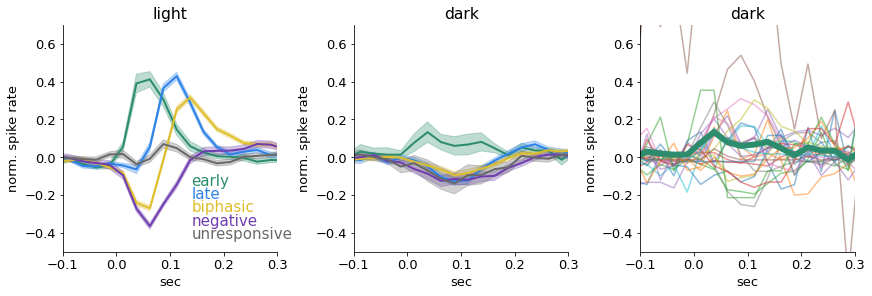

In [223]:
cluster_names = ['early','late','biphasic','negative','unresponsive']

fig = plt.figure(constrained_layout=True, figsize=(12,4))
spec = gridspec.GridSpec(nrows=1, ncols=3, figure=fig)

ax_light_summary = fig.add_subplot(spec[0,0])
ax_dark_summary = fig.add_subplot(spec[0,1])
ax_early = fig.add_subplot(spec[0,2])

for count, name in enumerate(cluster_names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_summary.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_light_summary.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=ltdk.cmap_movclusts[name], alpha=0.3)
ax_light_summary.set_xlim([-0.1,0.3]); ax_light_summary.set_ylim([-.5,.7])
# ax_light_summary.annotate('movement', xy=[0.19,-0.25], color=ltdk.cmap_movclusts['movement'], fontsize=15)
ax_light_summary.annotate('early', xy=[0.14,-0.15], color=ltdk.cmap_movclusts['early'], fontsize=15)
ax_light_summary.annotate('late', xy=[0.14,-0.22], color=ltdk.cmap_movclusts['late'], fontsize=15)
ax_light_summary.annotate('biphasic', xy=[0.14,-0.29], color=ltdk.cmap_movclusts['biphasic'], fontsize=15)
ax_light_summary.annotate('negative', xy=[0.14,-0.36], color=ltdk.cmap_movclusts['negative'], fontsize=15)
ax_light_summary.annotate('unresponsive', xy=[0.14,-0.43], color=ltdk.cmap_movclusts['unresponsive'], fontsize=15)
ax_light_summary.set_ylabel('norm. spike rate'); ax_light_summary.set_xlabel('sec')
ax_light_summary.set_title('light')

for count, name in enumerate(cluster_names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth_FmDk'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_summary.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_dark_summary.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=ltdk.cmap_movclusts[name], alpha=0.3)
ax_dark_summary.set_xlim([-0.1,0.3]); ax_dark_summary.set_ylim([-.5,.7])
ax_dark_summary.set_ylabel('norm. spike rate'); ax_dark_summary.set_xlabel('sec')
ax_dark_summary.set_title('dark')

data = flatten_series(ltdk.data['pref_gazeshift_psth_FmDk'][ltdk.data['movcluster']=='early'])
for x in range(np.size(data,0)):
    ax_early.plot(ltdk.trange_x, data[x,:], alpha=0.5)
ax_early.plot(ltdk.trange_x, np.mean(data,0), linewidth=6, color=ltdk.cmap_movclusts['early'])
ax_early.set_ylabel('norm. spike rate')
ax_early.set_xlabel('sec')
ax_early.set_title('dark')
ax_early.set_xlim([-0.1,0.3])
ax_early.set_ylim([-0.5,.7])

fig.savefig('/home/niell_lab/Desktop/lightdark_simple_summary.pdf')

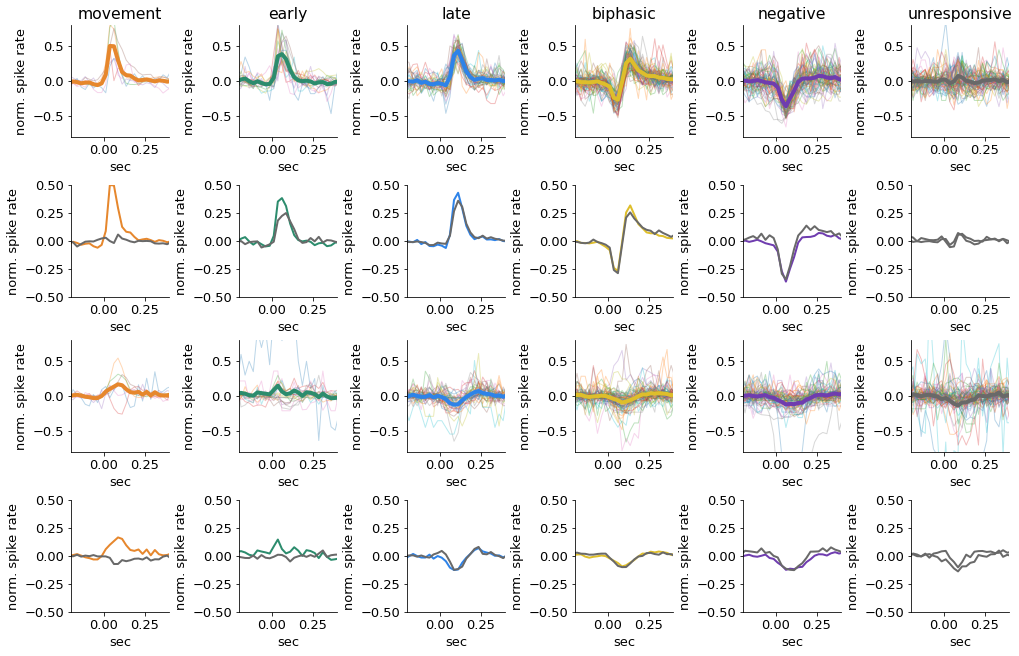

In [296]:
cluster_names = ['movement','early','late','biphasic','negative','unresponsive']

fig = plt.figure(constrained_layout=True, figsize=(14,9))
spec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig)

ax_early = fig.add_subplot(spec[0,1])
ax_early_m = fig.add_subplot(spec[0,0])
ax_late = fig.add_subplot(spec[0,2])
ax_biphasic = fig.add_subplot(spec[0,3])
ax_negative = fig.add_subplot(spec[0,4])
ax_unresp = fig.add_subplot(spec[0,5])

ax_early_pnp = fig.add_subplot(spec[1,1])
ax_early_m_pnp = fig.add_subplot(spec[1,0])
ax_late_pnp = fig.add_subplot(spec[1,2])
ax_biphasic_pnp = fig.add_subplot(spec[1,3])
ax_negative_pnp = fig.add_subplot(spec[1,4])
ax_unresp_pnp = fig.add_subplot(spec[1,5])

ax_early_d = fig.add_subplot(spec[2,1])
ax_early_m_d = fig.add_subplot(spec[2,0])
ax_late_d = fig.add_subplot(spec[2,2])
ax_biphasic_d = fig.add_subplot(spec[2,3])
ax_negative_d = fig.add_subplot(spec[2,4])
ax_unresp_d = fig.add_subplot(spec[2,5])

ax_early_pnp_d = fig.add_subplot(spec[3,1])
ax_early_m_pnp_d = fig.add_subplot(spec[3,0])
ax_late_pnp_d = fig.add_subplot(spec[3,2])
ax_biphasic_pnp_d = fig.add_subplot(spec[3,3])
ax_negative_pnp_d = fig.add_subplot(spec[3,4])
ax_unresp_pnp_d = fig.add_subplot(spec[3,5])

panels = [ax_early_m, ax_early, ax_late, ax_biphasic, ax_negative, ax_unresp]
pnp_panels = [ax_early_m_pnp, ax_early_pnp, ax_late_pnp, ax_biphasic_pnp, ax_negative_pnp, ax_unresp_pnp]
dark_panels = [ax_early_m_d, ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d, ax_unresp_d]
dark_pnp_panels = [ax_early_m_pnp_d, ax_early_pnp_d, ax_late_pnp_d, ax_biphasic_pnp_d, ax_negative_pnp_d, ax_unresp_pnp_d]

for c, name in enumerate(cluster_names):
    ax_light_psth = panels[c]
    ax_light_prefs = pnp_panels[c]
    ax_dark_psth = dark_panels[c]
    ax_dark_prefs = dark_pnp_panels[c]
    
    data = ltdk.data[ltdk.data['movcluster1']==name]
    
    for x in data['pref_gazeshift_psth']:
        ax_light_psth.plot(ltdk.trange_x, x, '-', linewidth=1, alpha=0.3)
    ax_light_psth.plot(ltdk.trange_x, np.nanmean(flatten_series(data['pref_gazeshift_psth']),0), '-', linewidth=4, color=ltdk.cmap_movclusts[name])
    ax_light_psth.set_xlim([-0.2,0.4]); ax_light_psth.set_ylim([-.8,.8])
    ax_light_psth.set_title(name)
    ax_light_psth.set_ylabel('norm. spike rate'); ax_light_psth.set_xlabel('sec')
    
    gaze_pref = np.nanmean(flatten_series(data['pref_gazeshift_psth']),0)
    gaze_nonpref = np.nanmean(flatten_series(data['nonpref_gazeshift_psth']),0)
    comp_pref = np.nanmean(flatten_series(data['pref_comp_psth']),0)
    comp_nonpref = np.nanmean(flatten_series(data['nonpref_comp_psth']),0)
    
    ax_light_prefs.plot(ltdk.trange_x, gaze_pref, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_light_prefs.plot(ltdk.trange_x, gaze_nonpref, '-', linewidth=2, color='dimgray')
#     ax_light_prefs.plot(ltdk.trange_x, comp_pref, '-', linewidth=2, color='tab:red')
#     ax_light_prefs.plot(ltdk.trange_x, comp_nonpref, '-', linewidth=2, color='lightcoral')
    ax_light_prefs.set_xlim([-0.2,0.4]); ax_light_prefs.set_ylim([-.5,.5])
    ax_light_prefs.set_ylabel('norm. spike rate'); ax_light_prefs.set_xlabel('sec')
    
    for x in data['pref_gazeshift_psth_FmDk']:
        ax_dark_psth.plot(ltdk.trange_x, x, '-', linewidth=1, alpha=0.3)
    ax_dark_psth.plot(ltdk.trange_x, np.nanmean(flatten_series(data['pref_gazeshift_psth_FmDk']),0), '-', linewidth=4, color=ltdk.cmap_movclusts[name])
    ax_dark_psth.set_xlim([-0.2,0.4]); ax_dark_psth.set_ylim([-.8,.8])
    ax_dark_psth.set_ylabel('norm. spike rate'); ax_dark_psth.set_xlabel('sec')
    
    gaze_pref = np.nanmean(flatten_series(data['pref_gazeshift_psth_FmDk']),0)
    gaze_nonpref = np.nanmean(flatten_series(data['nonpref_gazeshift_psth_FmDk']),0)
    comp_pref = np.nanmean(flatten_series(data['pref_comp_psth_FmDk']),0)
    comp_nonpref = np.nanmean(flatten_series(data['nonpref_comp_psth_FmDk']),0)
    
    ax_dark_prefs.plot(ltdk.trange_x, gaze_pref, '-', linewidth=2, color=ltdk.cmap_movclusts[name])
    ax_dark_prefs.plot(ltdk.trange_x, gaze_nonpref, '-', linewidth=2, color='dimgray')
#     ax_dark_prefs.plot(ltdk.trange_x, comp_pref, '-', linewidth=2, color='tab:red')
#     ax_dark_prefs.plot(ltdk.trange_x, comp_nonpref, '-', linewidth=2, color='lightcoral')
    ax_dark_prefs.set_xlim([-0.2,0.4]); ax_dark_prefs.set_ylim([-.5,.5])
    ax_dark_prefs.set_ylabel('norm. spike rate'); ax_dark_prefs.set_xlabel('sec')
    
fig.savefig('/home/niell_lab/Desktop/lightdark_details.pdf')

# Sparse noise, etc.

In [91]:
def norm_PSTH(x, pref=None, bckgnd=None):
    if pref is None:
        pref = x.copy()
    if bckgnd is not None:
        return (x-x[bckgnd]) / np.nanmax(np.abs(pref))
    else:
        return (x-np.mean(bckgnd)) / np.nanmax(np.abs(pref))

In [92]:
# bckgnd=[38,41]
bval = 39
for ind, row in hffm.data.iterrows():
    hffm.data.at[ind, 'norm_Rc_psth'] = norm_PSTH(row['Rc_psth'], bckgnd=bval).astype(object)
    if not np.isnan(row['Sn_on_background_psth']).all():
        Sn_selective_on = row['Sn_on_lightstim_psth'] - row['Sn_on_background_psth']
        hffm.data.at[ind, 'norm_Sn_selective_on'] = norm_PSTH(Sn_selective_on, bckgnd=bval).astype(object)
        hffm.data.at[ind, 'norm_Sn_background_on'] = norm_PSTH(row['Sn_on_background_psth'], bckgnd=bval).astype(object)
    if not np.isnan(row['Sn_off_background_psth']).all():
        Sn_selective_off = row['Sn_off_darkstim_psth'] - row['Sn_off_background_psth']
        hffm.data.at[ind, 'norm_Sn_selective_off'] = norm_PSTH(Sn_selective_off, bckgnd=bval).astype(object)
        hffm.data.at[ind, 'norm_Sn_background_off'] = norm_PSTH(row['Sn_off_background_psth'], bckgnd=bval).astype(object)
    if not np.isnan(row['Sn_on_all_psth']).all():
        hffm.data.at[ind, 'norm_Sn_on_all_psth'] = norm_PSTH(row['Sn_on_all_psth'], bckgnd=bval).astype(object)

In [93]:
thresh = 1.5
hffm.data['has_on_Sn_selective_resp'] = False
hffm.data['has_off_Sn_selective_resp'] = False

ons = np.zeros(len(hffm.data.index.values))
offs = np.zeros(len(hffm.data.index.values))
i = 0
for ind, row in hffm.data.iterrows():
    on = np.abs(row['norm_Sn_selective_on'])
    off = np.abs(row['norm_Sn_selective_off'])
    on_zscore = (np.max(on[35:45]) - np.mean(on)) / (np.std(on))
    off_zscore = (np.max(on[35:45]) - np.mean(off)) / (np.std(on))
    ons[i] = on_zscore
    offs[i] = off_zscore
    if on_zscore >= thresh:
        hffm.data.at[ind, 'has_on_Sn_selective_resp'] = True
    if off_zscore >= thresh:
        hffm.data.at[ind, 'has_off_Sn_selective_resp'] = True
    i += 1

In [94]:
def cropPSTH(x):
    x[hffm.trange_x<0] = np.nan
    x[hffm.trange_x>.2] = np.nan
    return x

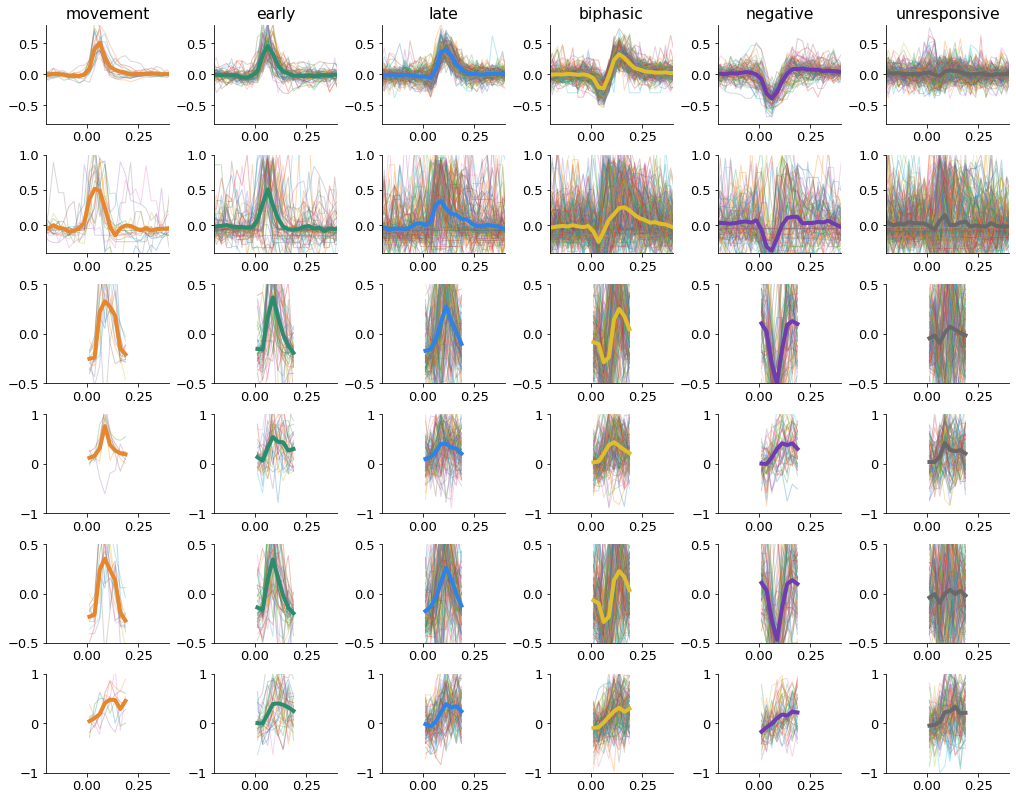

In [50]:
fig = plt.figure(constrained_layout=True, figsize=(14,11))
spec = gridspec.GridSpec(nrows=6, ncols=6, figure=fig)

ax_movement_sacc = fig.add_subplot(spec[0,0])
ax_movement_Rc = fig.add_subplot(spec[1,0])
ax_movement_gSn_on = fig.add_subplot(spec[2,0])
ax_movement_sSn_on = fig.add_subplot(spec[3,0])
ax_movement_gSn_off = fig.add_subplot(spec[4,0])
ax_movement_sSn_off = fig.add_subplot(spec[5,0])

ax_early_sacc = fig.add_subplot(spec[0,1])
ax_early_Rc = fig.add_subplot(spec[1,1])
ax_early_gSn_on = fig.add_subplot(spec[2,1])
ax_early_sSn_on = fig.add_subplot(spec[3,1])
ax_early_gSn_off = fig.add_subplot(spec[4,1])
ax_early_sSn_off = fig.add_subplot(spec[5,1])

ax_late_sacc = fig.add_subplot(spec[0,2])
ax_late_Rc = fig.add_subplot(spec[1,2])
ax_late_gSn_on = fig.add_subplot(spec[2,2])
ax_late_sSn_on = fig.add_subplot(spec[3,2])
ax_late_gSn_off = fig.add_subplot(spec[4,2])
ax_late_sSn_off = fig.add_subplot(spec[5,2])

ax_biphasic_sacc = fig.add_subplot(spec[0,3])
ax_biphasic_Rc = fig.add_subplot(spec[1,3])
ax_biphasic_gSn_on = fig.add_subplot(spec[2,3])
ax_biphasic_sSn_on = fig.add_subplot(spec[3,3])
ax_biphasic_gSn_off = fig.add_subplot(spec[4,3])
ax_biphasic_sSn_off = fig.add_subplot(spec[5,3])

ax_negative_sacc = fig.add_subplot(spec[0,4])
ax_negative_Rc = fig.add_subplot(spec[1,4])
ax_negative_gSn_on = fig.add_subplot(spec[2,4])
ax_negative_sSn_on = fig.add_subplot(spec[3,4])
ax_negative_gSn_off = fig.add_subplot(spec[4,4])
ax_negative_sSn_off = fig.add_subplot(spec[5,4])

ax_unresp_sacc = fig.add_subplot(spec[0,5])
ax_unresp_Rc = fig.add_subplot(spec[1,5])
ax_unresp_gSn_on = fig.add_subplot(spec[2,5])
ax_unresp_sSn_on = fig.add_subplot(spec[3,5])
ax_unresp_gSn_off = fig.add_subplot(spec[4,5])
ax_unresp_sSn_off = fig.add_subplot(spec[5,5])

sacc_panels = [ax_movement_sacc,ax_early_sacc,ax_late_sacc,ax_biphasic_sacc,ax_negative_sacc,ax_unresp_sacc]
Rc_panels = [ax_movement_Rc,ax_early_Rc,ax_late_Rc,ax_biphasic_Rc,ax_negative_Rc,ax_unresp_Rc]
gSn_on_panels = [ax_movement_gSn_on,ax_early_gSn_on,ax_late_gSn_on,ax_biphasic_gSn_on,ax_negative_gSn_on,ax_unresp_gSn_on]
sSn_on_panels = [ax_movement_sSn_on,ax_early_sSn_on,ax_late_sSn_on,ax_biphasic_sSn_on,ax_negative_sSn_on,ax_unresp_sSn_on]
gSn_off_panels = [ax_movement_gSn_off,ax_early_gSn_off,ax_late_gSn_off,ax_biphasic_gSn_off,ax_negative_gSn_off,ax_unresp_gSn_off]
sSn_off_panels = [ax_movement_sSn_off,ax_early_sSn_off,ax_late_sSn_off,ax_biphasic_sSn_off,ax_negative_sSn_off,ax_unresp_sSn_off]

cnames = ['movement','early','late','biphasic','negative','unresponsive']
for c, name in enumerate(cnames):
    sacc_panel = sacc_panels[c]
    Rc_panel = Rc_panels[c]
    gSn_on_panel = gSn_on_panels[c]
    sSn_on_panel = sSn_on_panels[c]
    gSn_off_panel = gSn_off_panels[c]
    sSn_off_panel = sSn_off_panels[c]
    
    data = hffm.data[hffm.data['movcluster1']==name]
    
    for x in data['pref_gazeshift_psth']:
        sacc_panel.plot(hffm.trange_x, x, linewidth=1, alpha=0.3)
    sacc = np.mean(flatten_series(data['pref_gazeshift_psth']),0)
    sacc_panel.plot(hffm.trange_x, sacc, color=ltdk.cmap_movclusts[name], linewidth=4)
    sacc_panel.set_xlim([-0.2,0.4]); sacc_panel.set_ylim([-0.8,0.8])
    sacc_panel.set_title(name)
    
    for x in data['norm_Rc_psth']:
        Rc_panel.plot(hffm.trange_x, x, linewidth=1, alpha=0.3)
    revcheck = np.nanmean(flatten_series(data['norm_Rc_psth']),0)
    Rc_panel.plot(hffm.trange_x, revcheck, color=ltdk.cmap_movclusts[name], linewidth=4)
    Rc_panel.set_xlim([-0.2,0.4]); Rc_panel.set_ylim([-0.4,1])
    
    for x in data['norm_Sn_background_on']:
        gSn_on_panel.plot(hffm.trange_x, cropPSTH(x), linewidth=1, alpha=0.3)
    gSn_on = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_background_on']),0))
    gSn_on_panel.plot(hffm.trange_x, gSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
    gSn_on_panel.set_xlim([-0.2,0.4]); gSn_on_panel.set_ylim([-0.5,0.5])
    
    for x in data['norm_Sn_selective_on'][data['has_on_Sn_selective_resp']==True]:
        sSn_on_panel.plot(hffm.trange_x, cropPSTH(x), linewidth=1, alpha=0.3)
    sSn_on = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_selective_on'][data['has_on_Sn_selective_resp']==True]),0))
    sSn_on_panel.plot(hffm.trange_x, sSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
    sSn_on_panel.set_xlim([-0.2,0.4]); sSn_on_panel.set_ylim([-1,1])
    
    for x in data['norm_Sn_background_off']:
        gSn_off_panel.plot(hffm.trange_x, cropPSTH(x), linewidth=1, alpha=0.3)
    gSn_off = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_background_off']),0))
    gSn_off_panel.plot(hffm.trange_x, gSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)
    gSn_off_panel.set_xlim([-0.2,0.4]); gSn_off_panel.set_ylim([-0.5,0.5])
    
    for x in data['norm_Sn_selective_off'][data['has_off_Sn_selective_resp']==True]:
        sSn_off_panel.plot(hffm.trange_x, cropPSTH(x), linewidth=1, alpha=0.3)
    sSn_off = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_selective_off'][data['has_off_Sn_selective_resp']==True]),0))
    sSn_off_panel.plot(hffm.trange_x, sSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)
    sSn_off_panel.set_xlim([-0.2,0.4]); sSn_off_panel.set_ylim([-1,1])
    
#     ax_sacc.plot(hffm.trange_x, sacc, color=ltdk.cmap_movclusts[name], linewidth=4)
#     ax_Rc.plot(hffm.trange_x, revcheck, color=ltdk.cmap_movclusts[name], linewidth=4)
#     ax_gSn_on.plot(hffm.trange_x, gSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
#     ax_sSn_on.plot(hffm.trange_x, sSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
#     ax_gSn_off.plot(hffm.trange_x, gSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)
#     ax_sSn_off.plot(hffm.trange_x, sSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)

# ax_sacc.set_xlim([-0.2,0.4]); ax_sacc.set_ylim([-0.5,0.5])
# ax_Rc.set_xlim([-0.2,0.4]); ax_Rc.set_ylim([-0.5,0.5])
# ax_gSn_on.set_xlim([-0.2,0.4]); ax_gSn_on.set_ylim([-0.5,0.5])
# ax_sSn_on.set_xlim([-0.2,0.4]); ax_sSn_on.set_ylim([-0.5,0.5])
# ax_gSn_off.set_xlim([-0.2,0.4]); ax_gSn_off.set_ylim([-0.5,0.5])
# ax_sSn_off.set_xlim([-0.2,0.4]); ax_sSn_off.set_ylim([-0.5,0.5])

fig.savefig('/home/niell_lab/Desktop/sparsenoise_details.pdf')

In [94]:
hffm.data[hffm.data['has_on_Sn_selective_resp']==True][hffm.data['has_off_Sn_selective_resp']==True][hffm.data['movcluster1']=='movement'].index.values

array([ 91, 136, 162, 188, 319, 394])

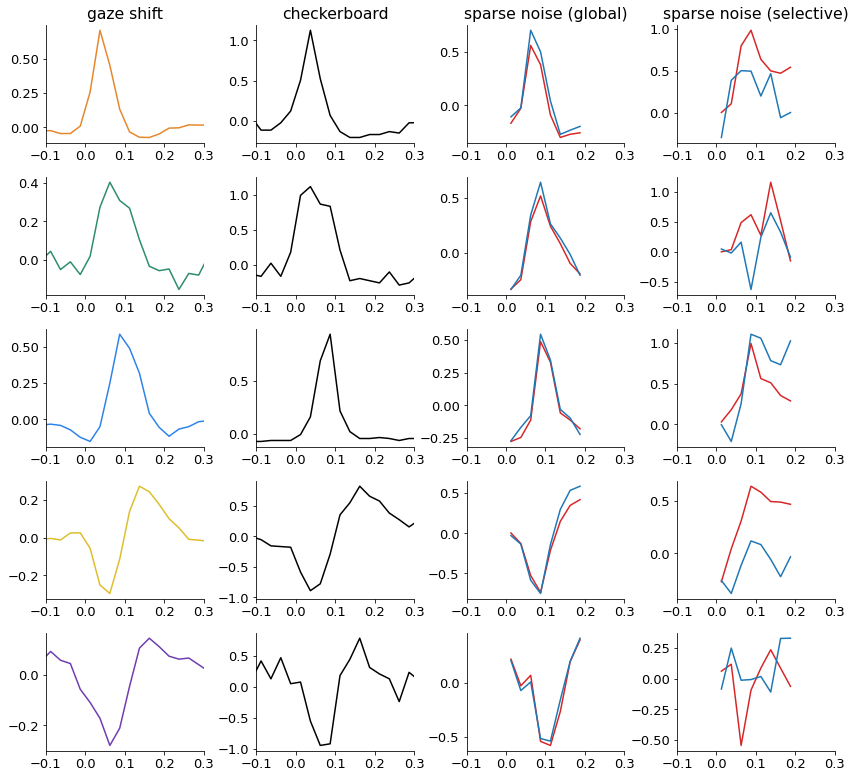

In [98]:
# 162 (motor)
# 97 (early)
# 98 (late)
# 118 (biphasic)
# 191 (negative)

units = [162,97,98,118,191]

plt.subplots(5,4,figsize=(12,11))

count = 1
for i, ind in enumerate(units):
    row = hffm.data.loc[ind]
    
    ax = plt.subplot(5,4,count)
    ax.plot(hffm.trange_x, row['pref_gazeshift_psth'], color=hffm.cmap_movclusts[row['movcluster1']])
    ax.set_xlim([-0.1,0.3])
    if count==1:
        ax.set_title('gaze shift')
    count += 1
    
    ax = plt.subplot(5,4,count)
    ax.plot(hffm.trange_x, row['norm_Rc_psth'], 'k')
    ax.set_xlim([-0.1,0.3])
    if count==2:
        ax.set_title('checkerboard')
    count += 1
    
    if row['has_on_Sn_selective_resp'] and row['has_off_Sn_selective_resp']:
        ax = plt.subplot(5,4,count)
        ax.plot(hffm.trange_x, cropPSTH(row['norm_Sn_background_on']), color='tab:red')
        ax.plot(hffm.trange_x, cropPSTH(row['norm_Sn_background_off']), color='tab:blue')
        ax.set_xlim([-0.1,0.3])
        if count==3:
            ax.set_title('sparse noise (global)')
        count += 1
    
        ax = plt.subplot(5,4,count)
        ax.plot(hffm.trange_x, cropPSTH(row['norm_Sn_selective_on']), color='tab:red')
        ax.plot(hffm.trange_x, cropPSTH(row['norm_Sn_selective_off']), color='tab:blue')
        ax.set_xlim([-0.1,0.3])
        if count==4:
            ax.set_title('sparse noise (selective)')
        count += 1
    
    else:
        count += 2

plt.tight_layout()

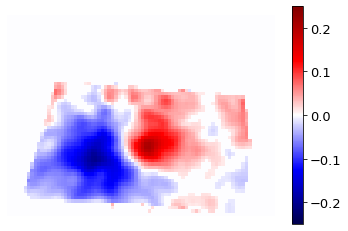

In [120]:
sta = hffm.data.loc[162,'Wn_spike_triggered_average'].copy()
sta[np.abs(sta)<0.01] = 0
sta_range = np.nanmax(np.abs(sta))*1.2
plt.imshow(sta, cmap='seismic', vmin=-sta_range, vmax=sta_range)
plt.axis('off')
plt.colorbar()

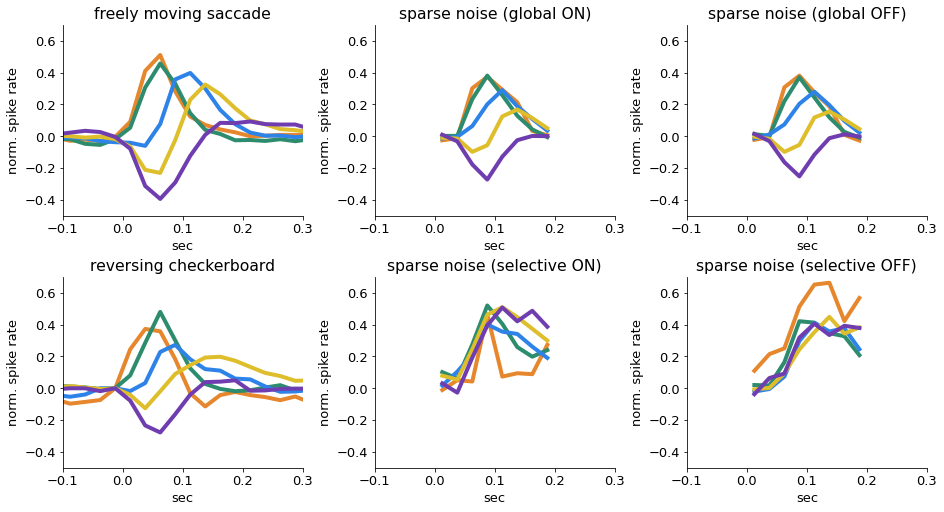

In [67]:
fig = plt.figure(constrained_layout=True, figsize=(13,7))
spec = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

ax_sacc = fig.add_subplot(spec[0,0])
ax_Rc = fig.add_subplot(spec[1,0])
ax_gSn_on = fig.add_subplot(spec[0,1])
ax_sSn_on = fig.add_subplot(spec[1,1])
ax_gSn_off = fig.add_subplot(spec[0,2])
ax_sSn_off = fig.add_subplot(spec[1,2])

cnames = ['movement','early','late','biphasic','negative']
for c, name in enumerate(cnames):
    
    data = hffm.data[hffm.data['movcluster1']==name]
    
    sacc = np.mean(flatten_series(data['pref_gazeshift_psth']),0)
    revcheck = np.nanmean(flatten_series(data['norm_Rc_psth']),0)
    gSn_on = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_background_on']),0))
    sSn_on = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_selective_on'][data['has_on_Sn_selective_resp']==True]),0))
    gSn_off = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_background_off']),0))
    sSn_off = cropPSTH(np.nanmean(flatten_series(data['norm_Sn_selective_off'][data['has_off_Sn_selective_resp']==True]),0))
    
    ax_sacc.plot(hffm.trange_x, sacc, color=ltdk.cmap_movclusts[name], linewidth=4)
    ax_Rc.plot(hffm.trange_x, revcheck, color=ltdk.cmap_movclusts[name], linewidth=4)
    ax_gSn_on.plot(hffm.trange_x, gSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
    ax_sSn_on.plot(hffm.trange_x, sSn_on, color=ltdk.cmap_movclusts[name], linewidth=4)
    ax_gSn_off.plot(hffm.trange_x, gSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)
    ax_sSn_off.plot(hffm.trange_x, sSn_off, color=ltdk.cmap_movclusts[name], linewidth=4)

ax_sacc.set_xlim([-0.1,0.3]); ax_sacc.set_ylim([-0.5,0.7]); ax_sacc.set_ylabel('norm. spike rate'); ax_sacc.set_xlabel('sec')
ax_Rc.set_xlim([-0.1,0.3]); ax_Rc.set_ylim([-0.5,0.7]); ax_Rc.set_ylabel('norm. spike rate'); ax_Rc.set_xlabel('sec')
ax_gSn_on.set_xlim([-0.1,0.3]); ax_gSn_on.set_ylim([-0.5,0.7]); ax_gSn_on.set_ylabel('norm. spike rate'); ax_gSn_on.set_xlabel('sec')
ax_sSn_on.set_xlim([-0.1,0.3]); ax_sSn_on.set_ylim([-0.5,0.7]); ax_sSn_on.set_ylabel('norm. spike rate'); ax_sSn_on.set_xlabel('sec')
ax_gSn_off.set_xlim([-0.1,0.3]); ax_gSn_off.set_ylim([-0.5,0.7]); ax_gSn_off.set_ylabel('norm. spike rate'); ax_gSn_off.set_xlabel('sec')
ax_sSn_off.set_xlim([-0.1,0.3]); ax_sSn_off.set_ylim([-0.5,0.7]); ax_sSn_off.set_ylabel('norm. spike rate'); ax_sSn_off.set_xlabel('sec')

ax_sacc.set_title('freely moving saccade')
ax_Rc.set_title('reversing checkerboard')
ax_gSn_on.set_title('sparse noise (global ON)')
ax_sSn_on.set_title('sparse noise (selective ON)')
ax_gSn_off.set_title('sparse noise (global OFF)')
ax_sSn_off.set_title('sparse noise (selective OFF)')

fig.savefig('/home/niell_lab/Desktop/sparsenoise_summary.pdf')

(-0.05, 0.25, -0.45, 0.55)

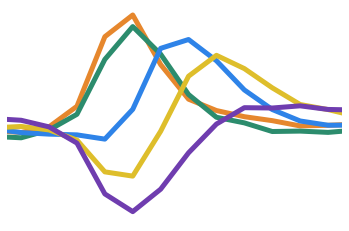

In [79]:
cnames = ['movement','early','late','biphasic','negative']
for c, name in enumerate(cnames):
    data = hffm.data[hffm.data['movcluster1']==name]
    sacc = np.mean(flatten_series(data['pref_gazeshift_psth']),0)
    plt.plot(hffm.trange_x, sacc, color=ltdk.cmap_movclusts[name], linewidth=5)
plt.xlim([-0.05,0.25])
plt.ylim([-.45,.55])
plt.axis('off')

(-0.05, 0.25, -0.45, 0.55)

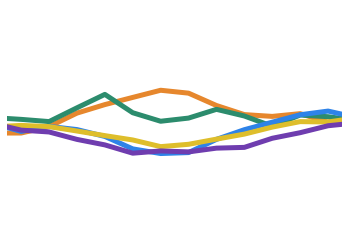

In [80]:
cnames = ['movement','early','late','biphasic','negative']
for c, name in enumerate(cnames):
    data = ltdk.data[ltdk.data['movcluster1']==name]
    sacc = np.mean(flatten_series(data['pref_gazeshift_psth_FmDk']),0)
    plt.plot(hffm.trange_x, sacc, color=ltdk.cmap_movclusts[name], linewidth=5)
plt.xlim([-0.05,0.25])
plt.ylim([-.45,.55])
plt.axis('off')

(-0.5449999999999999,
 1.5449999999999995,
 0.9610512254802511,
 13.24994992005675)

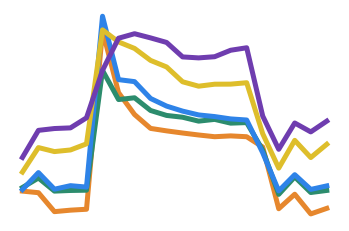

In [86]:
cnames = ['movement','early','late','biphasic','negative']
for c, name in enumerate(cnames):
    data = hffm.data[hffm.data['movcluster1']==name][hffm.data['responsive_to_gratings']==True]
    sacc = np.mean(flatten_series(data['Gt_grating_psth']),0)
    plt.plot(hffm.grat_psth_x, sacc, color=hffm.cmap_movclusts[name], linewidth=5)
# plt.xlim([-0.05,0.25])
# plt.ylim([-.45,.55])
plt.axis('off')

(-0.05, 0.25, -0.45, 0.55)

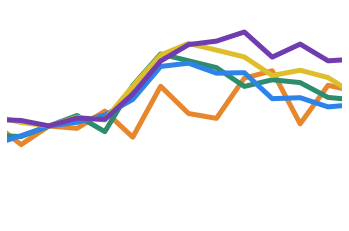

In [102]:
cnames = ['movement','early','late','biphasic','negative']
for c, name in enumerate(cnames):
    data = hffm.data[hffm.data['movcluster1']==name]
    sacc = np.nanmean(flatten_series(data['norm_Sn_selective_on']),0)
    plt.plot(hffm.trange_x, sacc, color=hffm.cmap_movclusts[name], linewidth=5)
plt.xlim([-0.05,0.25])
plt.ylim([-.45,.55])
plt.axis('off')

In [97]:
hffm.data['norm_Rc_psth']

0      [-0.052631578947368654, 0.5263157894736863, 0....
1      [-0.3, 0.0, -0.49999999999999994, -0.6, -0.6, ...
2      [-0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0....
3      [0.1666666666666674, 0.6666666666666696, 0.500...
4      [-0.40000000000000174, 0.0, -0.500000000000002...
                             ...                        
711    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
712    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
713    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
714    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
715    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: norm_Rc_psth, Length: 716, dtype: object

In [203]:
len(ltdk.data[ltdk.data['movcluster1']=='movement'].index.values)

7

In [204]:
len(ltdk.data.index.values)

269

In [205]:
7/269

0.026022304832713755

In [224]:
len(hffm.data[hffm.data['movcluster1']=='movement'].index.values)

16

In [225]:
len(hffm.data.index.values)

716

In [226]:
16/716

0.0223463687150838